# Spaceship Titanic
Reto de Inteligencia artificial avanzada para la ciencia de datos I

-------------------------------------------------

**Equipo 2:**

Alan Alcántara Ávila A01753505

Leonardo Cossío Dinorín A01753898

Julián Cisneros Cortés A01747363

Luis David Maza Ramírez A01747890

Diego Zurita Villarreal A01748227

------------------------------------------------

El reto consiste en implementar un modelo de clasificación para la competencia "Spaceship Titanic" en kaggle, este deberá predecir correctamente si un pasajero fue transportado o no a otra dimensión. También deberá conectarse con una aplicación web desde la cual un usuario pueda enviar la información necesaria y recibir el resultado del modelo.

Para este proyecto decidimos hacer un "Tinder interdimencional" llamado Space Soulmates, con el cual el usuario puede ingresar los datos de una manera intercativa e intuitiva para hacer una predicción. Una vez el usuario hace "match" con alguien, la página web muestra un mensaje diciendo si puede abordar con su alma gemela a un viaje interdimensional.

#Importación de librerías

In [ ]:
!pip install scikit_posthocs
!pip install baycomp
!pip install catboost

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18029 sha256=8f976ab869a0bc880e9a9309a13d2ed9d1fe4a2330426c28200e1f169802239e
  Stored in directory: /root/.cache/pip/wheels/8a/aa/61/8f1e79a2be629eaa2a72b495c56bb667568dac7c33f4e4c408
Successfully built baycomp
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [ ]:
# 1. Importar bibliotecas ----------------------------------------------------------------------------------------------------------------------------
import pandas as pd
import baycomp  #type: ignore
import numpy as np
import joblib
import matplotlib.pyplot as plt #type: ignore
import seaborn as sns #type: ignore
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV   #type: ignore
from sklearn.metrics import  make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix    #type: ignore
from tqdm import tqdm   #type: ignore
from collections import Counter
from sklearn.impute import KNNImputer #type: ignore
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Clasificadores
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier   #type: ignore
from sklearn.svm import SVC #type: ignore
from sklearn.neighbors import KNeighborsClassifier   #type: ignore
from sklearn.tree import DecisionTreeClassifier  #type: ignore
from xgboost import XGBClassifier    #type: ignore
import matplotlib.pyplot as plt #type: ignore
import scikit_posthocs as sp    #type: ignore
from catboost import CatBoostClassifier  #type: ignore

# Dataset

### Limpieza de datos

El dataset fue obtenido de https://www.kaggle.com/competitions/spaceship-titanic/data

La columna a predecir es *Transported* (y) utilizando los datos de las demas columnas (X)

Al analizarlo nos dimos cuenta que el dataset tenía valores faltantes y que además diversas columnas podían ser transformadas utilizando one-hot encoding.

**Cambios importantes:**

La columna "PassegnerId" tenía un formato gggg-pp, donde el primer valor es el ID del grupo al que pertenecen y el segundo es el número del pasajero dentro de ese mismo grupo, por lo que decidimos quedarnos solo con el primer número y en base a eso determinar si la persona viaja acompañada o sola.

- Se creó la columna *Has_family* y se eliminó la columna *PassengerId*

Las columna *HomePlanet* y *Destination* fueron transformadas utilizando la técnica de One Hot Encoding, pues solamente había 3 diferentes valores en cada una de ellas.

- Se crearon 6 columnas binarias nuevas donde cada una representa un lugar de origen o destino.

La columna *Cabin* también es importante al momento de la predicción, sin embargo, el formato que tenía nos causaba problemas, pues cada objeto estaba compuesto de 3 valores representando deck/num/side. Lo que hicimos fue separar dichos valores, deck tenía valores String de la A a la G o T, mientras que side solo contaba con dos valores diferentes: P (Port) y S (Starboard), estos dos valores son importantes puesto a que revela la posición de cada pasajero en la nave y es altamente probable que eso influya en el resultado de la columna a predecir.

- Se dividieron los valores de la columna *Cabin* en 3:
  - Deck: Se aplicó un label encoding debido a que son valores ordinales (Orden del alfabeto).
  - Side: Se aplicó un One-Hot Encoding debido a que solamente existen dos posibles valores (P o S).
  - Num: Esta columna fue eliminada debido a que los valores presentes no parecían indicar datos muy relevantes y existía una alta varianza entre ellos.

El resto de las columnas ya eran directamente valores numéricos, por lo que no se realizaron más modificaciones.

**Imputación de datos:**

Los valores faltantes fueron rellenados utilizando la moda (En caso de *age*) y se rellenó con ceros en las columnas restantes (Columnas de gastos y columnas de cryosleep y VIP) pues la mayoría de datos eran 0 en esas columnas.

### Funciones de data cleaning

In [ ]:
# 2. Data Cleaning ----------------------------------------------------------------------------------------------------------------------------
# Separar datos numéricos y categóricos
def num_cat_separation(X):
    df_num = X.select_dtypes(include = ["int64", "float64"])
    df_cat = X.select_dtypes(include = ["object"])

    return df_cat, df_num

# Crear los diccionarios de conteo de clases y valores faltantes
def storeMS(df):
  class_counts = {}
  missing_values = {}

  for col in df.columns:
    class_count = Counter(df[col].dropna())  # Excluir valores faltantes al contar clases
    class_counts[col] = class_count
    missing_values[col] = df[col].isnull().sum()

  return class_counts, missing_values

# Tratamiento de datos CATEGÓRICOS
def cat_KNN_cleaning(df_cat, col):
    # Imputación predictiva o basada en KNN
    df_cat[col] = df_cat[col].fillna("NotApply")

    return df_cat

# Tratamiento de datos NUMÉRICOS (KNN)
def num_KNN_cleaning(df_num, col):
    imputer = KNNImputer(n_neighbors=3)
    df_imputed = imputer.fit_transform(df_num[[col]])
    df_num[col] = df_imputed

    return df_num

# Rellenar datos numéricos y faltantes usando imputación
def fill_data(DF, llave, column):
  if llave == "Moda":
    DF[column] = DF[column].fillna(DF[column].mode()[0])
  elif llave == "NewCat":
    if pd.api.types.is_numeric_dtype(DF[column]):
      DF[column] = DF[column].fillna(0.0)
    else:
      DF[column] = DF[column].fillna(False)
  else:
    if pd.api.types.is_numeric_dtype(DF[column]):
      num_KNN_cleaning(DF, column)
    else:
      cat_KNN_cleaning(DF, column)

#Hacer la imputación de cada columna dependiendo la sugerencia
def imputation(df, class_counts, missing_values):
  for col, counts in class_counts.items():
      if missing_values[col] != 0:
        most_common_class, most_common_count = counts.most_common(1)[0]
        total_non_null = sum(counts.values())

        if most_common_count / total_non_null < 0.5:
            fill_data(df, "Moda", col)
        elif missing_values[col] / len(df) < 0.05:
            fill_data(df, "NewCat", col)
        else:
            fill_data(df, "KNN", col)

# Realiza label encoding
def label_encoding(df, col):
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])
  return df

# Realiza one-hot encoding
def one_hot_encoding(df, cols):
  one_hot = pd.get_dummies(df, columns=cols)
  return one_hot

# Realiza una codificación dependiendo del tipo de columna
def encode_dataframe(df):
  for col in df:
    if col == "PassengerId":
      df['group'] = df['PassengerId'].str.split('_').str[0]
      group_counts = df['group'].value_counts()
      df['Has_family'] = df['group'].map(lambda x: True if group_counts[x] > 1 else False)
      df.drop(columns=['PassengerId', 'group'], inplace=True)
    elif col == "Cabin":
      df[['Deck', 'Side']] = df['Cabin'].str.split('/', expand=True).iloc[:, [0, 2]]
      df = label_encoding(df, 'Deck')
      df = pd.get_dummies(df, columns=['Side'])
      df.drop(columns=['Cabin'], inplace=True)
    elif col == "HomePlanet" or col == "Destination":
      df = one_hot_encoding(df, [col])
    else:
      pass
  return df

# Combina los DataFrames de datos numéricos y categóricos
def combine_num_cat(df_cat, df_num):
    # Aseguramos que los índices coinciden
    if not df_cat.index.equals(df_num.index):
        df_cat = df_cat.reset_index(drop=True)
        df_num = df_num.reset_index(drop=True)

    # Combina los DataFrames por columnas
    df_combined = pd.concat([df_cat, df_num], axis=1)

    return df_combined

## Preparación del dataset

### Dataset original

In [ ]:
# Random state de la aleatorización de los datos
shuffle_random_state = 127
split_random_state = 88

# Leer datos
df = pd.read_csv("train.csv")

# Aleatorizar los datos para evitar el desbalanceo de clases
df_shuffled = shuffle(df, random_state=shuffle_random_state)

print("df_shuffled random_state: ", shuffle_random_state)

df_shuffled.head()

df_shuffled random_state:  127


PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
5070     5416_03       Mars      True  F/1114/P    TRAPPIST-1e  18.0  False   
6380     6745_01      Earth     False  F/1400/P  PSO J318.5-22  28.0  False   
947      1008_01     Europa      True    C/39/S    55 Cancri e  39.0  False   
2276     2445_01      Earth     False   E/170/S            NaN  43.0  False   
2609     2793_01      Earth     False   E/169/P    TRAPPIST-1e  48.0  False   

      RoomService  FoodCourt  ShoppingMall   Spa  VRDeck             Name  \
5070          0.0        0.0           0.0   0.0     0.0          Ech Saf   
6380        545.0        0.0         501.0   0.0     0.0   Jimmyn Mcinton   
947           0.0        0.0           0.0   0.0     0.0  Wasatz Spistory   
2276        602.0        3.0          27.0  89.0    69.0     Sanney Lerez   
2609        784.0       87.0           0.0   0.0     1.0   Darrie Mcinton   

      Transported  
5070         True  
6380        False  
947          True  
2276        False  
2609         True

In [ ]:
df_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 5070 to 8252
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 959.3+ KB


### Dataset procesado

In [ ]:
# Separar train y test
x_train, x_test, y_train, y_test = train_test_split(
    df_shuffled.drop(columns=["Name", "Transported"]),
    df_shuffled["Transported"],
    test_size=0.2,                    # El test será el 20% del dataset de entrenamiento
    random_state=split_random_state
)

print("split random_state: ", split_random_state)

# Separar datos numéricos y categóricos
df_cat, df_num = num_cat_separation(x_train)

# Codifica los datos categóricos
df_cat = encode_dataframe(df_cat)

# Crear los diccionarios de conteo de clases y valores faltantes
class_counts_num, missing_values_num = storeMS(df_num)
class_counts_cat, missing_values_cat = storeMS(df_cat)

# Imputación de datos
imputation(df_num, class_counts_num, missing_values_num)
imputation(df_cat, class_counts_cat, missing_values_cat)

# Combina los DataFrames de datos numéricos y categóricos
df_new = combine_num_cat(df_cat, df_num)

# Separar datos numéricos y categóricos para el conjunto de prueba
df_cat_test, df_num_test = num_cat_separation(x_test)

# Codifica los datos categóricos
df_cat_test = encode_dataframe(df_cat_test)

# Crear los diccionarios de conteo de clases y valores faltantes
class_counts_num_test, missing_values_num_test = storeMS(df_num_test)
class_counts_cat_test, missing_values_cat_test = storeMS(df_cat_test)

# Imputación de datos
imputation(df_num_test, class_counts_num_test, missing_values_num_test)
imputation(df_cat_test, class_counts_cat_test, missing_values_cat_test)

df_new_test = combine_num_cat(df_cat_test, df_num_test)

df_new.head()

split random_state:  88


CryoSleep    VIP  Has_family  HomePlanet_Earth  HomePlanet_Europa  \
7645      False  False        True              True              False   
3955      False  False        True             False              False   
541        True  False        True             False               True   
2521      False  False       False              True              False   
16        False  False       False             False              False   

      HomePlanet_Mars  Deck  Side_P  Side_S  Destination_55 Cancri e  \
7645            False     6   False    True                    False   
3955             True     5    True   False                    False   
541             False     2    True   False                     True   
2521            False     5   False    True                    False   
16               True     5    True   False                     True   

      Destination_PSO J318.5-22  Destination_TRAPPIST-1e   Age  RoomService  \
7645                      False                     True   9.0          0.0   
3955                      False                     True  40.0       1268.0   
541                       False                    False  16.0          0.0   
2521                       True                    False  23.0          3.0   
16                        False                    False  27.0       1286.0   

      FoodCourt  ShoppingMall  Spa  VRDeck  
7645        0.0           0.0  0.0     0.0  
3955        0.0           0.0  0.0     0.0  
541         0.0           0.0  0.0     0.0  
2521      548.0          37.0  0.0    12.0  
16        122.0           0.0  0.0     0.0

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 7645 to 8450
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6954 non-null   bool   
 1   VIP                        6954 non-null   bool   
 2   Has_family                 6954 non-null   bool   
 3   HomePlanet_Earth           6954 non-null   bool   
 4   HomePlanet_Europa          6954 non-null   bool   
 5   HomePlanet_Mars            6954 non-null   bool   
 6   Deck                       6954 non-null   int64  
 7   Side_P                     6954 non-null   bool   
 8   Side_S                     6954 non-null   bool   
 9   Destination_55 Cancri e    6954 non-null   bool   
 10  Destination_PSO J318.5-22  6954 non-null   bool   
 11  Destination_TRAPPIST-1e    6954 non-null   bool   
 12  Age                        6954 non-null   float64
 13  RoomService                6954 non-null   float64

# Elección de modelo de clasificación

Para decidir qué modelo de clasificación utilizaríamos, se decidió comparar directamente diferentes modelos utilizando el accuracy obtenido y evaluando diferencias críticas y comparaciones bayesianas.

In [ ]:
# 3. Definición, entrenamiento y evaluación de clasificadores ----------------------------------------------------------------------------------------
# Definir los clasificadores
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Classifier': SVC(),
    'KNN Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

# Definir las métricas para la validación cruzada
# Le damos prioridad al accuracy, para saber el porcantaje de predcciones correctas, pero también evaluamos otras métricas importantes
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall':  make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1': make_scorer(f1_score, average='macro')
}

# Evaluar los clasificadores utilizando 5-fold cross-validation y guardar los resultados por cada métrica
results:dict = {}
for name, model in tqdm(classifiers.items(), desc="Evaluando Modelos"):
    results[name] = {}
    for metric_name, metric in tqdm(scoring.items(), desc=f"Evaluando métricas para {name}", leave=False):
        scores = cross_val_score(model, df_new, y_train, cv=5, scoring=metric)
        results[name][metric_name] = scores                                                             # Guardar los 5 resultados individuales

# Convertir los resultados a un DataFrame para cada métrica
acc_df = pd.DataFrame({model: results[model]['Accuracy'] for model in classifiers.keys()}).abs()        # Convertir a valores positivos
rec_df = pd.DataFrame({model: results[model]['Recall'] for model in classifiers.keys()}).abs()          # Convertir a valores positivos
pres_df = pd.DataFrame({model: results[model]['Precision'] for model in classifiers.keys()}).abs()      # Convertir a valores positivos
f1_df = pd.DataFrame({model: results[model]['F1'] for model in classifiers.keys()}).abs()               # Convertir a valores positivos

# Imprimir cada métrica por DataFrame
# Resultados para Accuracy
print("DataFrame de Accuracy (10 resultados por modelo):")
print(acc_df)
print("\n")

# Resultados para Recall
print("DataFrame de Recall (10 resultados por modelo):")
print(rec_df)
print("\n")

# Resultados para Precision
print("DataFrame de Precision (10 resultados por modelo):")
print(pres_df)
print("\n")

# Resultados para F1
print("DataFrame de F1 (10 resultados por modelo):")
print(f1_df)
print("\n")

Evaluando Modelos:  33%|███▎      | 3/9 [02:34<05:04, 50.79s/it]
Evaluando métricas para Support Vector Classifier:   0%|          | 0/4 [00:00<?, ?it/s]
Evaluando métricas para Support Vector Classifier:  25%|██▌       | 1/4 [00:07<00:23,  7.76s/it]
Evaluando métricas para Support Vector Classifier:  50%|█████     | 2/4 [00:14<00:13,  6.97s/it]
Evaluando métricas para Support Vector Classifier:  75%|███████▌  | 3/4 [00:21<00:07,  7.27s/it]
Evaluando métricas para Support Vector Classifier: 100%|██████████| 4/4 [00:29<00:00,  7.41s/it]
Evaluando Modelos: 100%|██████████| 9/9 [03:43<00:00, 24.87s/it]

DataFrame de Accuracy (10 resultados por modelo):
   Random Forest  CatBoost  Gradient Boosting  Support Vector Classifier  \
0       0.778577  0.793674           0.801582                   0.790079   
1       0.782171  0.782890           0.776420                   0.769950   
2       0.792236  0.801582           0.802301                   0.785047   
3       0.795111  0.808771           0.810927                   0.793674   
4       0.766906  0.794964           0.797842                   0.786331   

   KNN Classifier  Decision Tree  AdaBoost   XGBoost  Extra Trees  
0        0.753415       0.734723  0.790798  0.795830     0.770669  
1        0.767074       0.731848  0.768512  0.780014     0.767074  
2        0.781452       0.738318  0.800144  0.782171     0.769231  
3        0.787922       0.745507  0.798706  0.800863     0.786485  
4        0.779856       0.712230  0.775540  0.772662     0.763309  


DataFrame de Recall (10 resultados por modelo):
   Random Forest  CatBoost  Gradien

### Promedio de las métricas

Al utilizar el accuracy, las gráficas no mostraban una diferencia significativa, pues todos los modelos oscilaban entre accuracy de 72% y 80%.

Sin embargo, al imprimir los valores de dicha métrica nos dimos cuenta que Gradient Boosting y Catboost tenían las calificaciones más altas.

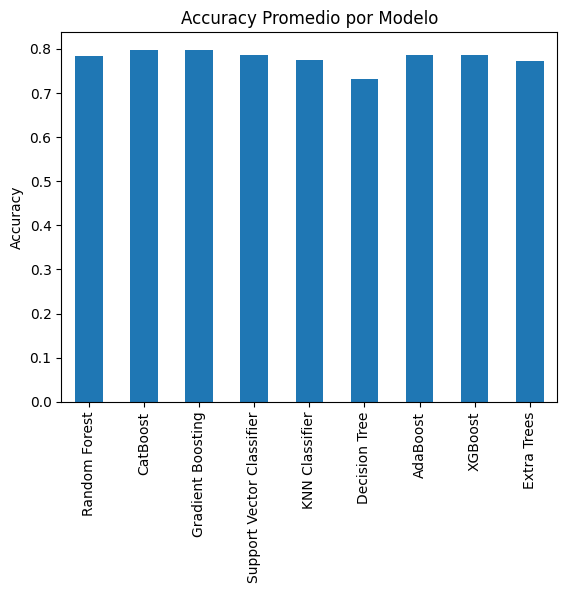

Random Forest                0.783000
CatBoost                     0.796376
Gradient Boosting            0.797814
Support Vector Classifier    0.785016
KNN Classifier               0.773944
Decision Tree                0.732525
AdaBoost                     0.786740
XGBoost                      0.786308
Extra Trees                  0.771353
dtype: float64


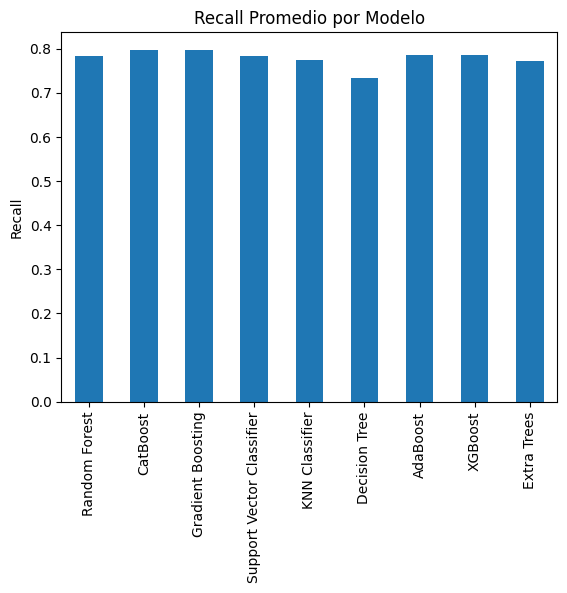

Random Forest                0.783353
CatBoost                     0.796195
Gradient Boosting            0.797426
Support Vector Classifier    0.784105
KNN Classifier               0.773922
Decision Tree                0.732459
AdaBoost                     0.786441
XGBoost                      0.786288
Extra Trees                  0.771761
dtype: float64


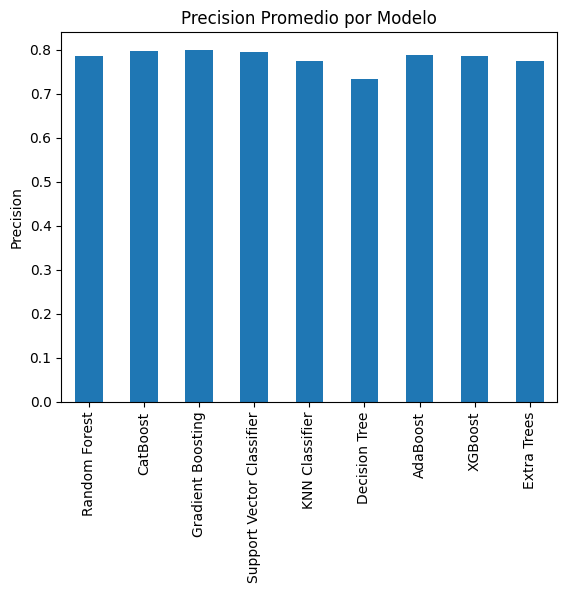

Random Forest                0.785046
CatBoost                     0.797173
Gradient Boosting            0.799955
Support Vector Classifier    0.796026
KNN Classifier               0.774215
Decision Tree                0.732872
AdaBoost                     0.788006
XGBoost                      0.786852
Extra Trees                  0.773707
dtype: float64


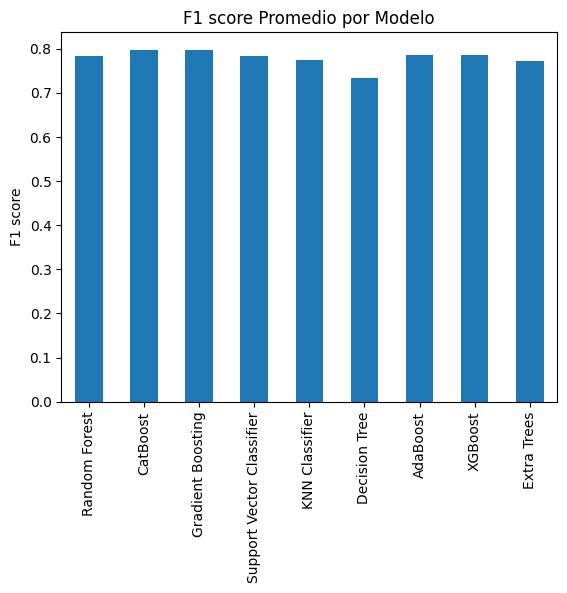

Random Forest                0.782733
CatBoost                     0.796166
Gradient Boosting            0.797298
Support Vector Classifier    0.782623
KNN Classifier               0.773864
Decision Tree                0.732381
AdaBoost                     0.786368
XGBoost                      0.786192
Extra Trees                  0.771019
dtype: float64


In [ ]:
# 4. Análisis y visualización de métricas individuales ------------------------------------------------------------------------------------------------------------
# Calcular promedios
acc_mean = acc_df.mean()
rec_mean = rec_df.mean()
pres_mean = pres_df.mean()
f1_mean = f1_df.mean()

# Visualizar los resultados
acc_mean.plot(kind='bar', title='Accuracy Promedio por Modelo')
plt.ylabel('Accuracy')
plt.show()
print(acc_mean)

rec_mean.plot(kind='bar', title='Recall Promedio por Modelo')
plt.ylabel('Recall')
plt.show()
print(rec_mean)

pres_mean.plot(kind='bar', title='Precision Promedio por Modelo')
plt.ylabel('Precision')
plt.show()
print(pres_mean)

f1_mean.plot(kind='bar', title='F1 score Promedio por Modelo')
plt.ylabel('F1 score')
plt.show()
print(f1_mean)

### Diferencias críticas

Para poder evaluar mejor las difefrencias existentes entre los modelos probados, se decidió graficar las diferencias críticas, de esta manera tendríamos más claro qué modelo de clasificación nos favorecería en este problema.

Nos dimos cuenta que Catboost era la mejor opción en cuanto a accuracy, que era la métrica que decidimos evaluar principalmente.

Random Forest                5.2
CatBoost                     8.0
Gradient Boosting            8.4
Support Vector Classifier    5.2
KNN Classifier               3.3
Decision Tree                1.0
AdaBoost                     5.6
XGBoost                      6.0
Extra Trees                  2.3
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


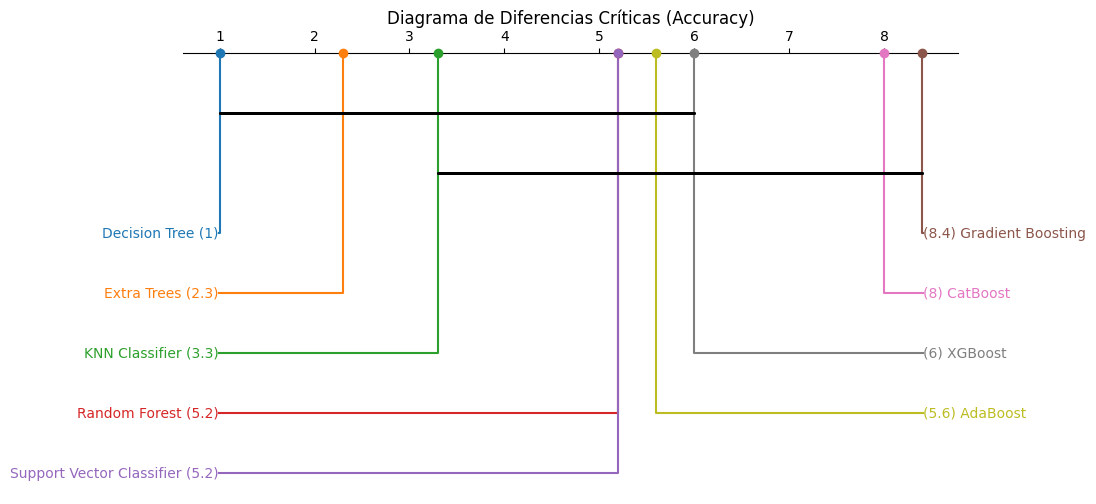

Random Forest                5.2
CatBoost                     8.0
Gradient Boosting            8.4
Support Vector Classifier    5.2
KNN Classifier               3.2
Decision Tree                1.0
AdaBoost                     5.6
XGBoost                      6.0
Extra Trees                  2.4
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


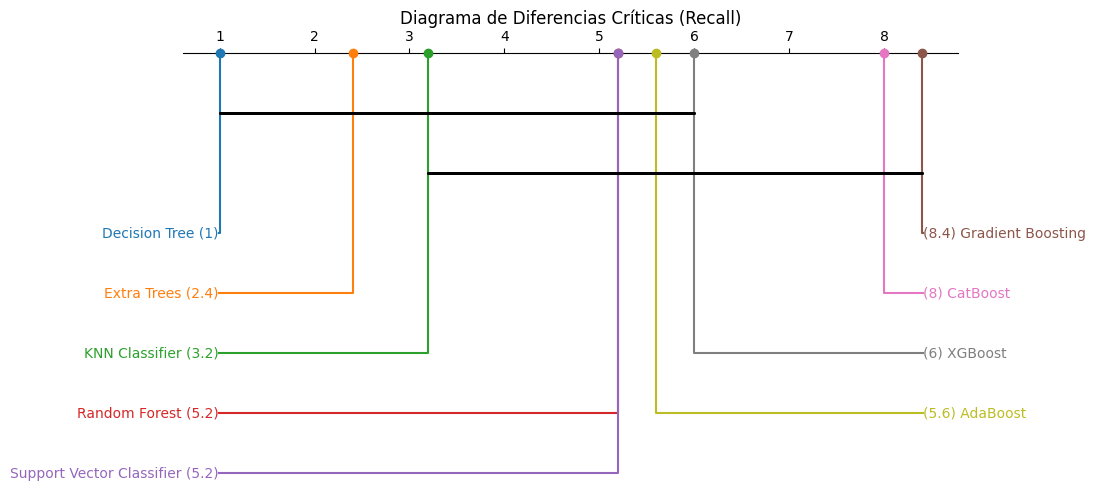

Random Forest                5.2
CatBoost                     7.4
Gradient Boosting            8.0
Support Vector Classifier    7.0
KNN Classifier               3.2
Decision Tree                1.0
AdaBoost                     5.2
XGBoost                      5.6
Extra Trees                  2.4
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


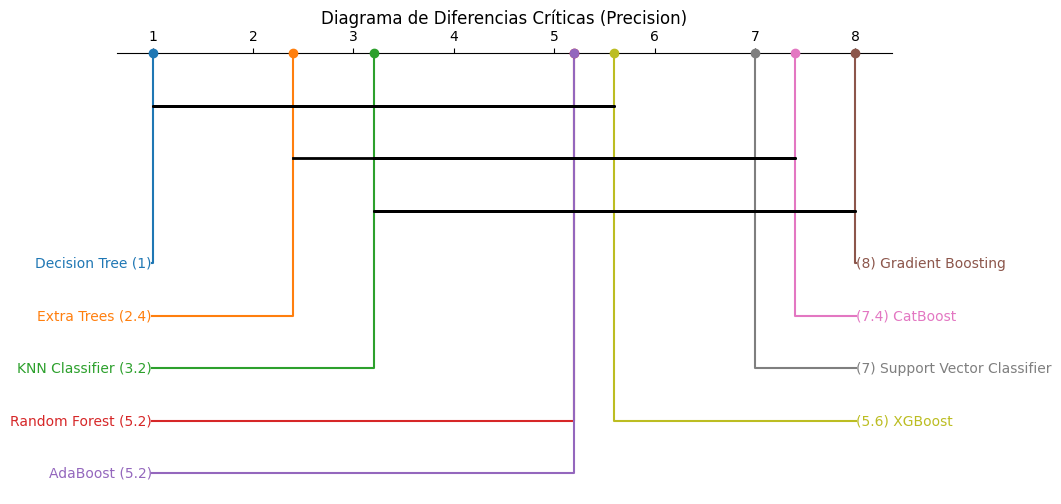

Random Forest                5.2
CatBoost                     8.0
Gradient Boosting            8.4
Support Vector Classifier    5.0
KNN Classifier               3.4
Decision Tree                1.0
AdaBoost                     5.8
XGBoost                      6.0
Extra Trees                  2.2
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:498: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key=lambda x: ranks[list(x)].min()
/usr/local/lib/python3.10/dist-packages/scikit_posthocs/_plotting.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


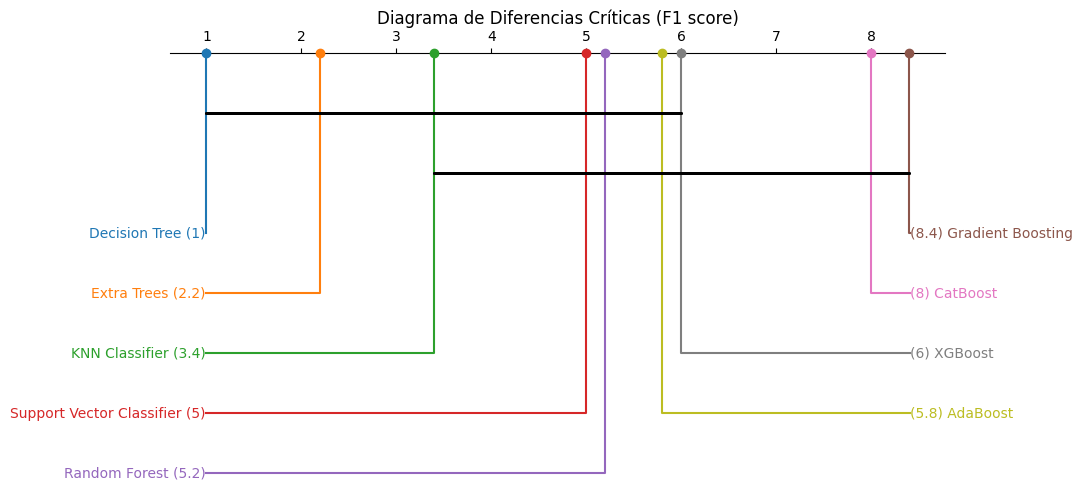

In [ ]:
# 5. Análisis de diferencias críticas -----------------------------------------------------------------------------------------------------------------
# Función para calcular y visualizar diferencias críticas entre modelos usando la librería de scikit-posthocs
def calcular_diferencias_criticas(df, metric_name):
    try:
        # Calcular los rangos de los modelos
        avg_rank = df.rank(axis=1).mean(axis=0)
        print(avg_rank)

        # Realizar una prueba de Nemenyi post-hoc
        cd_result = sp.posthoc_nemenyi_friedman(df.values)

        # Graficar el diagrama de diferencias críticas
        plt.figure(figsize=(10, 6), dpi=100)
        plt.title(f'Diagrama de Diferencias Críticas ({metric_name})')
        sp.critical_difference_diagram(avg_rank, cd_result)
        plt.show()

    except ValueError as e:
        print(f"Error al calcular diferencias críticas para {metric_name}: {e}")

# Calcular y graficar las diferencias críticas para cada métrica
calcular_diferencias_criticas(acc_df, 'Accuracy')
calcular_diferencias_criticas(rec_df, 'Recall')
calcular_diferencias_criticas(pres_df, 'Precision')
calcular_diferencias_criticas(f1_df, 'F1 score')

### Comparación bayesiana

Como las métricas entre CatBoost y Gradient Boosting eran muy similares, decidimos utilizar la técnica de comparación bayesiana para saber en qué proporción es mejor cada modelo con respecto a otro, teniendo como objetivo ver la gráfica de Catboost vs Gradient Boosting en accuracy.

Comparación bayesiana entre Random Forest y CatBoost en Accuracy: (0.05763406593092002, 0.94236593406908)


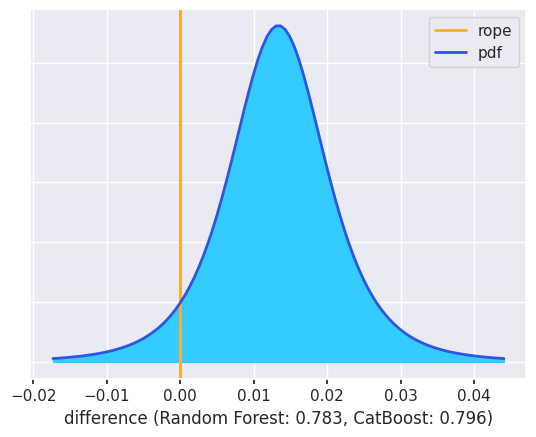

Comparación bayesiana entre Random Forest y Gradient Boosting en Accuracy: (0.09373259813782275, 0.9062674018621772)


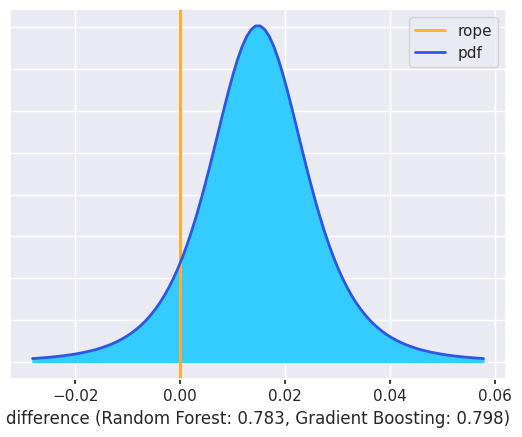

Comparación bayesiana entre Random Forest y Support Vector Classifier en Accuracy: (0.4152725745572371, 0.5847274254427629)


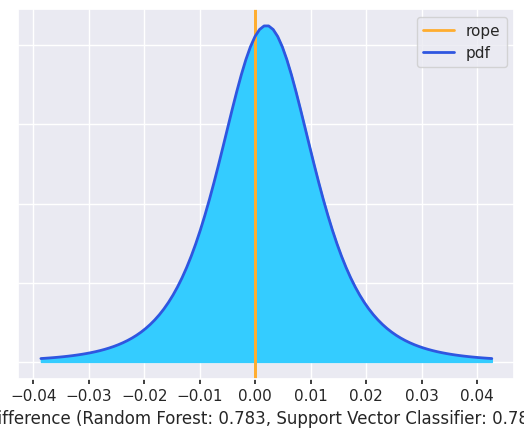

Comparación bayesiana entre Random Forest y KNN Classifier en Accuracy: (0.8048963920409876, 0.19510360795901238)


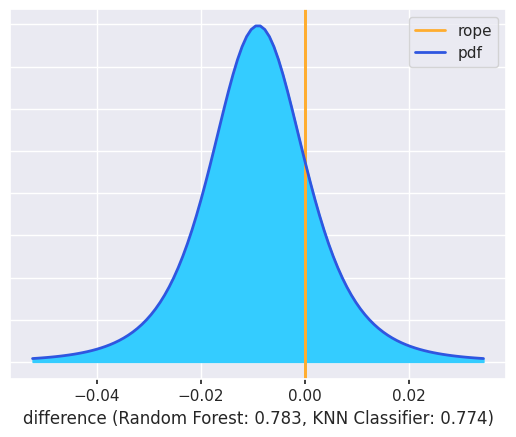

Comparación bayesiana entre Random Forest y Decision Tree en Accuracy: (0.9999685436116554, 3.145638834456399e-05)


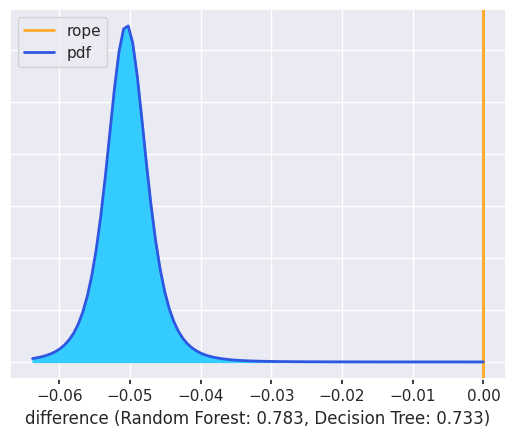

Comparación bayesiana entre Random Forest y AdaBoost en Accuracy: (0.30684678220339046, 0.6931532177966095)


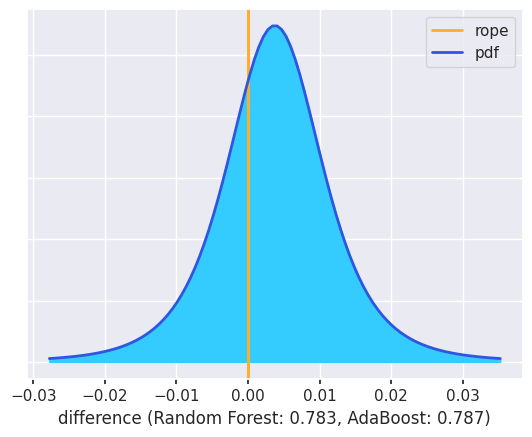

Comparación bayesiana entre Random Forest y XGBoost en Accuracy: (0.32683714952743537, 0.6731628504725646)


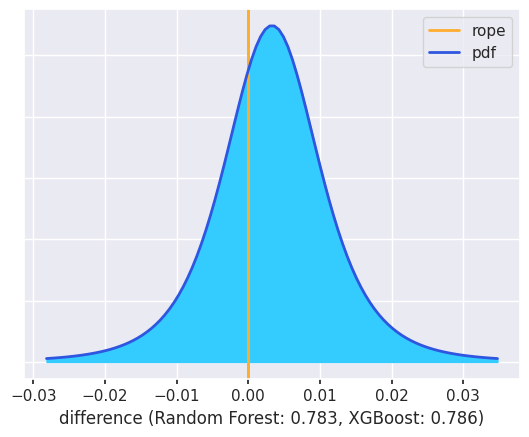

Comparación bayesiana entre Random Forest y Extra Trees en Accuracy: (0.9583286129918267, 0.0416713870081733)


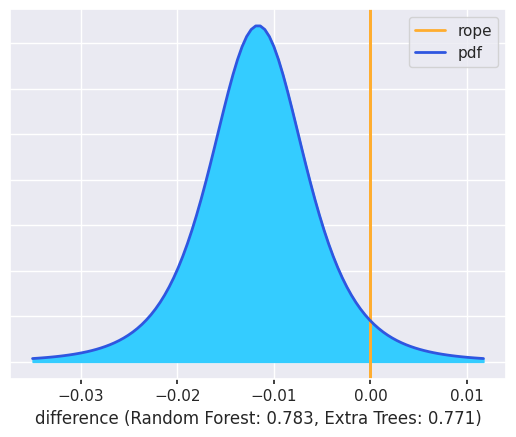

Comparación bayesiana entre CatBoost y Gradient Boosting en Accuracy: (0.3502048433655083, 0.6497951566344917)


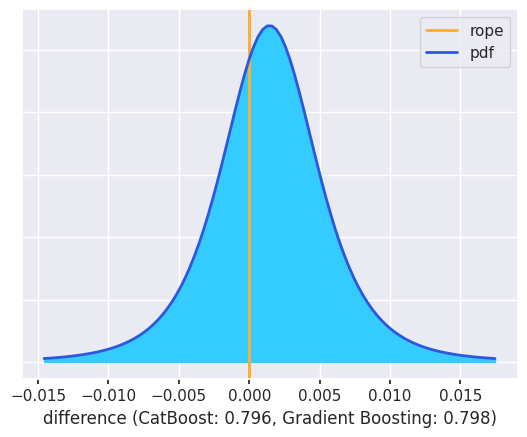

Comparación bayesiana entre CatBoost y Support Vector Classifier en Accuracy: (0.9837824516513636, 0.016217548348636424)


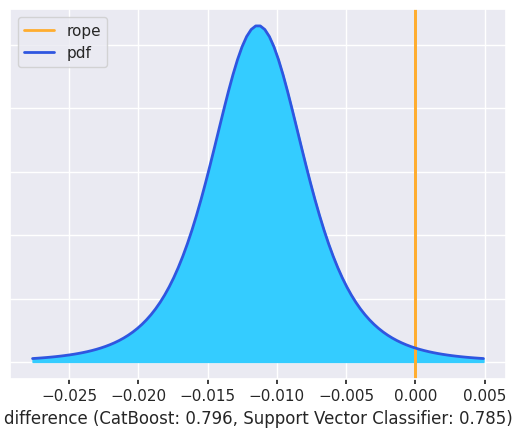

Comparación bayesiana entre CatBoost y KNN Classifier en Accuracy: (0.9843376168344617, 0.01566238316553825)


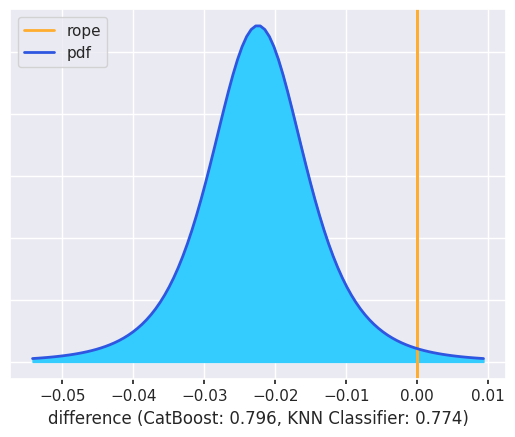

Comparación bayesiana entre CatBoost y Decision Tree en Accuracy: (0.9993838127658208, 0.0006161872341792218)


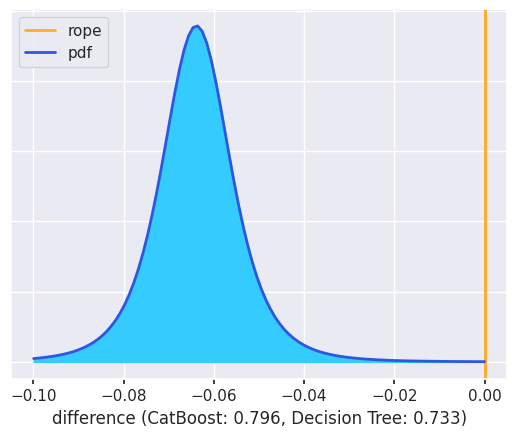

Comparación bayesiana entre CatBoost y AdaBoost en Accuracy: (0.9340204747820106, 0.06597952521798944)


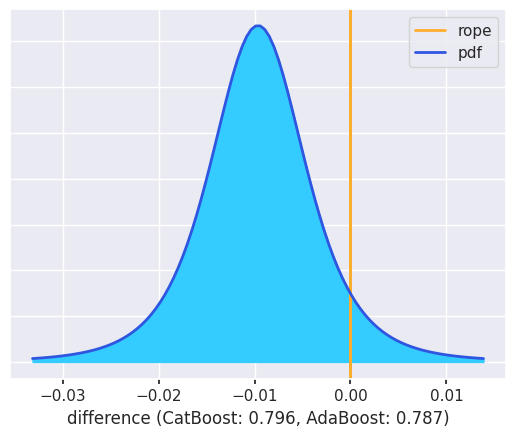

Comparación bayesiana entre CatBoost y XGBoost en Accuracy: (0.8865552870272186, 0.11344471297278136)


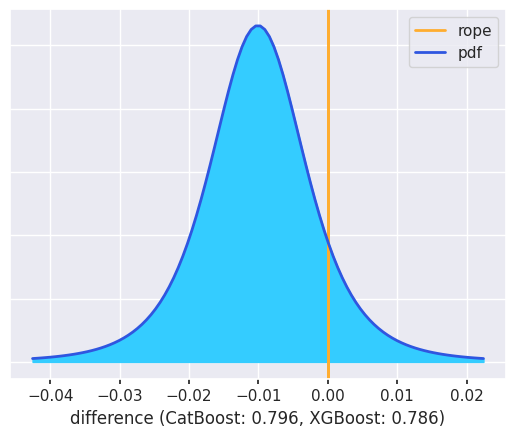

Comparación bayesiana entre CatBoost y Extra Trees en Accuracy: (0.9970690911456662, 0.0029309088543337802)


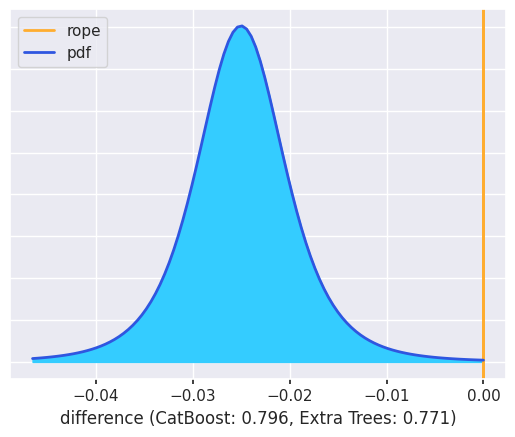

Comparación bayesiana entre Gradient Boosting y Support Vector Classifier en Accuracy: (0.993075174102078, 0.006924825897921982)


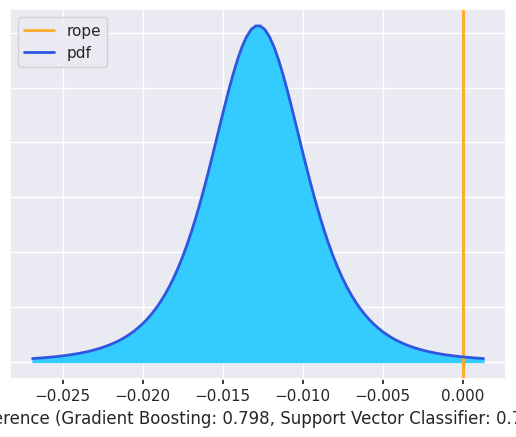

Comparación bayesiana entre Gradient Boosting y KNN Classifier en Accuracy: (0.9646668519524887, 0.03533314804751131)


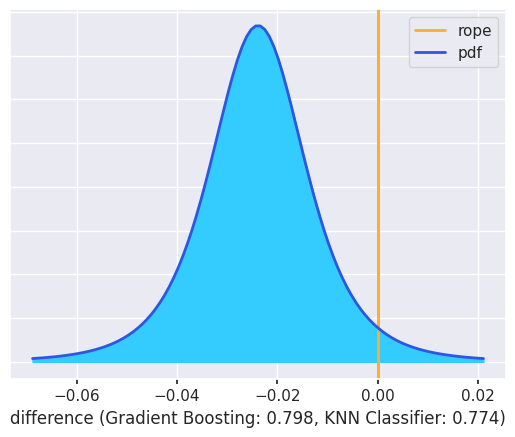

Comparación bayesiana entre Gradient Boosting y Decision Tree en Accuracy: (0.9987024242266656, 0.0012975757733344473)


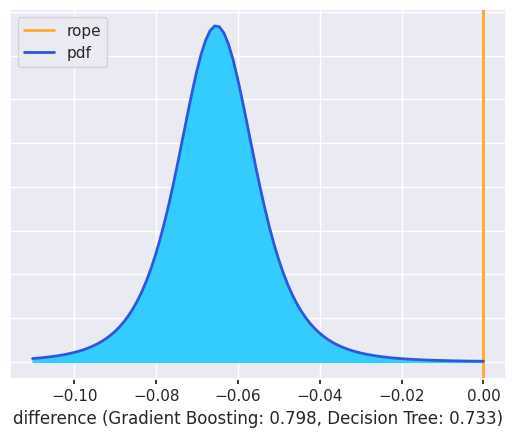

Comparación bayesiana entre Gradient Boosting y AdaBoost en Accuracy: (0.9557526734333038, 0.044247326566696166)


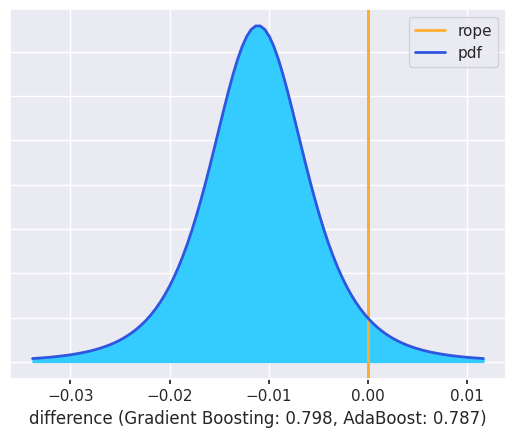

Comparación bayesiana entre Gradient Boosting y XGBoost en Accuracy: (0.895730442407879, 0.10426955759212098)


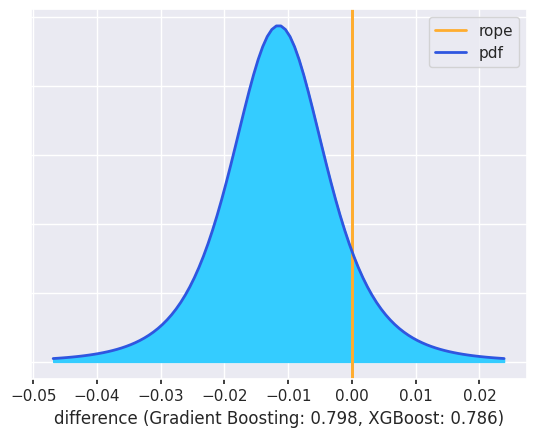

Comparación bayesiana entre Gradient Boosting y Extra Trees en Accuracy: (0.9906418422208253, 0.009358157779174703)


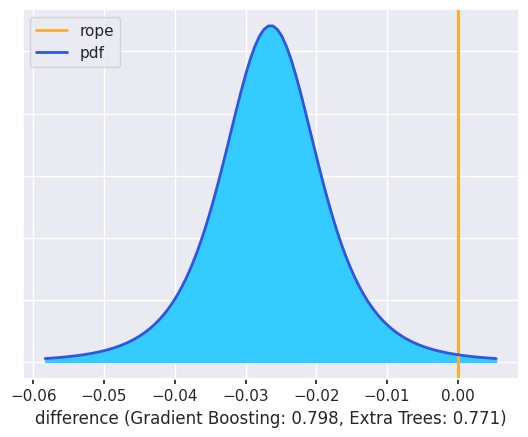

Comparación bayesiana entre Support Vector Classifier y KNN Classifier en Accuracy: (0.8424376280432626, 0.1575623719567374)


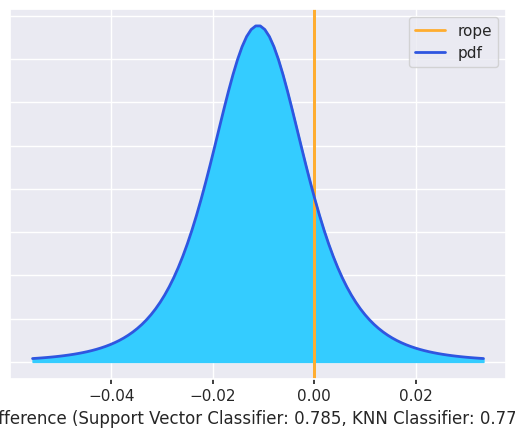

Comparación bayesiana entre Support Vector Classifier y Decision Tree en Accuracy: (0.9977691254816521, 0.002230874518347914)


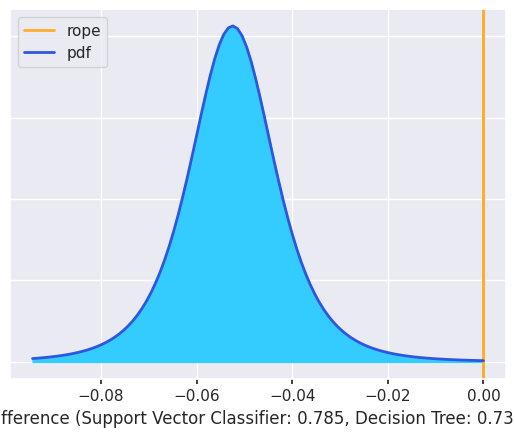

Comparación bayesiana entre Support Vector Classifier y AdaBoost en Accuracy: (0.39959705766896114, 0.6004029423310389)


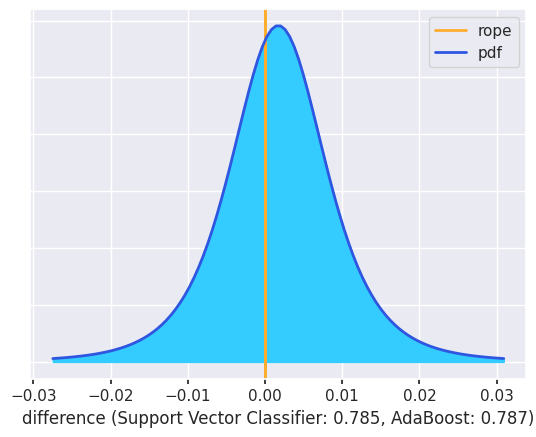

Comparación bayesiana entre Support Vector Classifier y XGBoost en Accuracy: (0.425798963085511, 0.574201036914489)


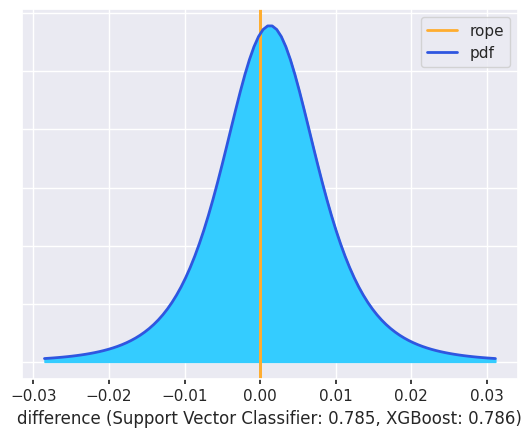

Comparación bayesiana entre Support Vector Classifier y Extra Trees en Accuracy: (0.963583318118206, 0.03641668188179403)


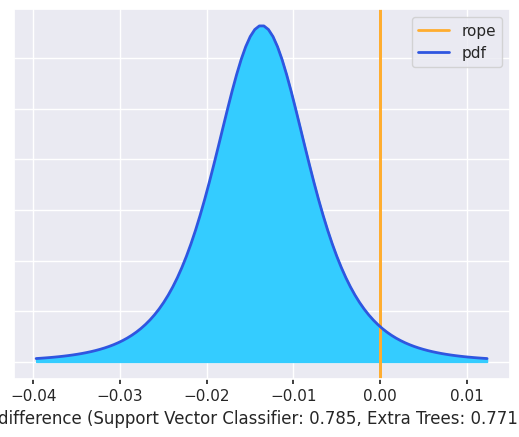

Comparación bayesiana entre KNN Classifier y Decision Tree en Accuracy: (0.9875392111594206, 0.01246078884057944)


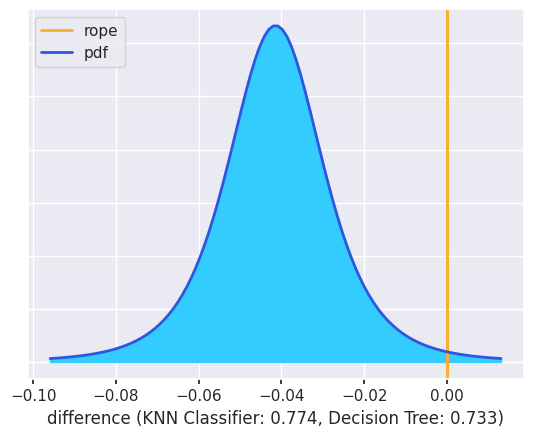

Comparación bayesiana entre KNN Classifier y AdaBoost en Accuracy: (0.15367317465700836, 0.8463268253429916)


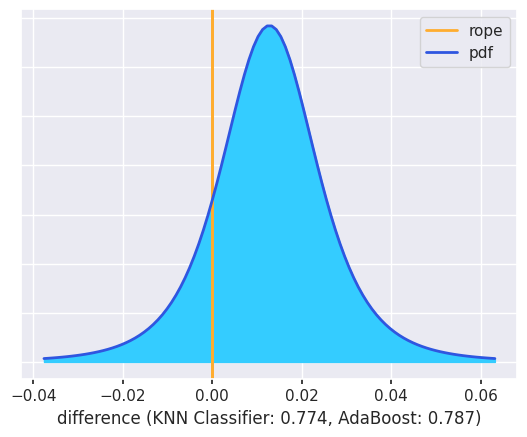

Comparación bayesiana entre KNN Classifier y XGBoost en Accuracy: (0.19181577250556936, 0.8081842274944306)


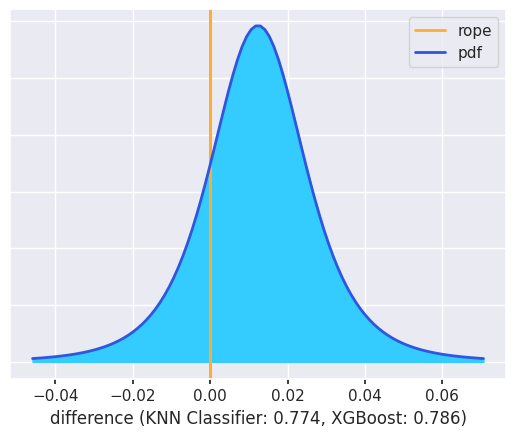

Comparación bayesiana entre KNN Classifier y Extra Trees en Accuracy: (0.6083630326843397, 0.39163696731566033)


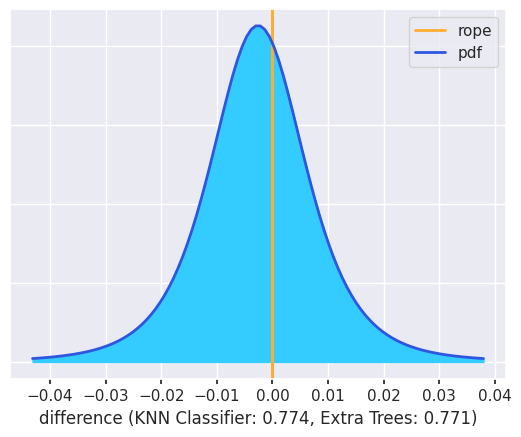

Comparación bayesiana entre Decision Tree y AdaBoost en Accuracy: (0.0008069164532653605, 0.9991930835467346)


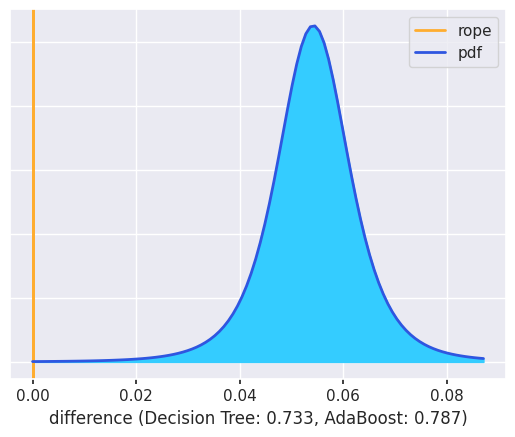

Comparación bayesiana entre Decision Tree y XGBoost en Accuracy: (0.00022726249822169198, 0.9997727375017783)


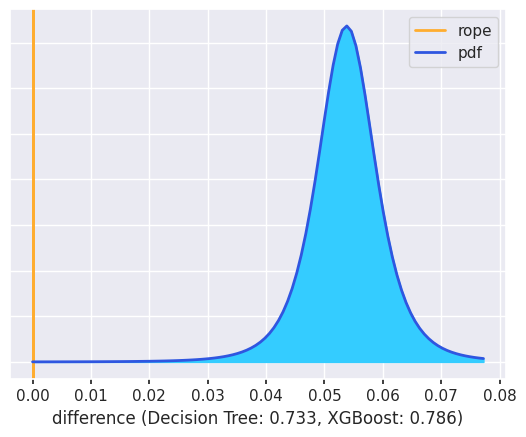

Comparación bayesiana entre Decision Tree y Extra Trees en Accuracy: (0.000848085915601593, 0.9991519140843984)


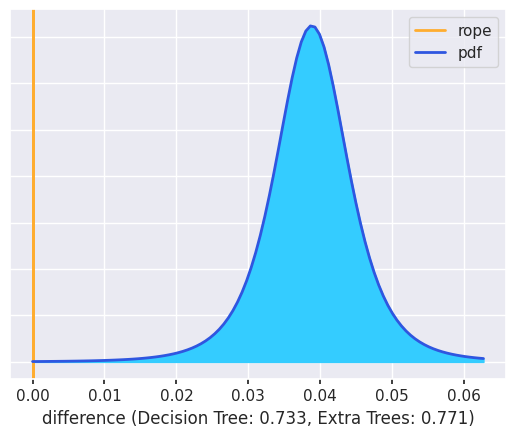

Comparación bayesiana entre AdaBoost y XGBoost en Accuracy: (0.5217331166380841, 0.4782668833619159)


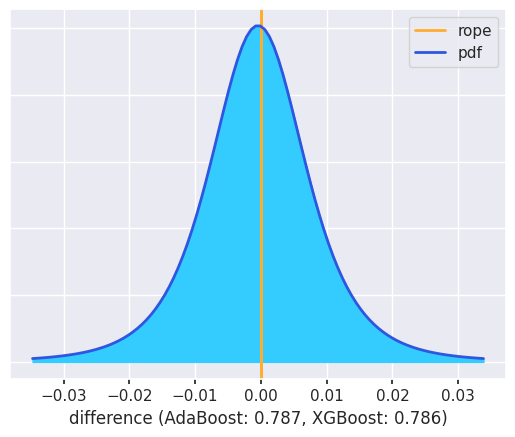

Comparación bayesiana entre AdaBoost y Extra Trees en Accuracy: (0.94805310908189, 0.05194689091811)


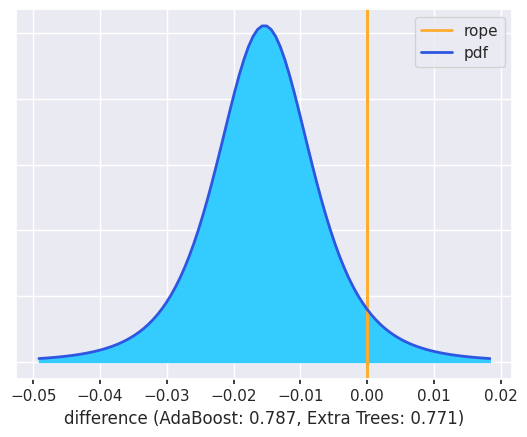

Comparación bayesiana entre XGBoost y Extra Trees en Accuracy: (0.9897206282478478, 0.010279371752152211)


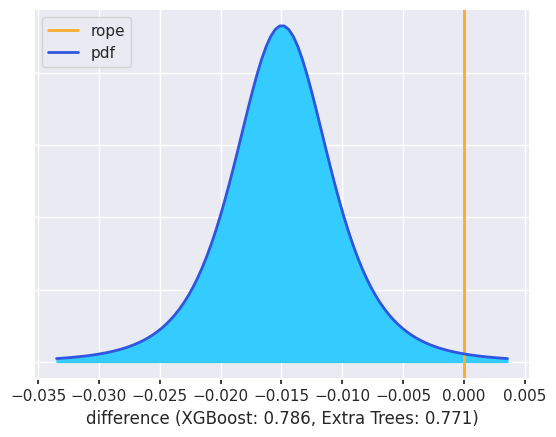

Comparación bayesiana entre Random Forest y CatBoost en Recall: (0.06238737165468211, 0.9376126283453179)


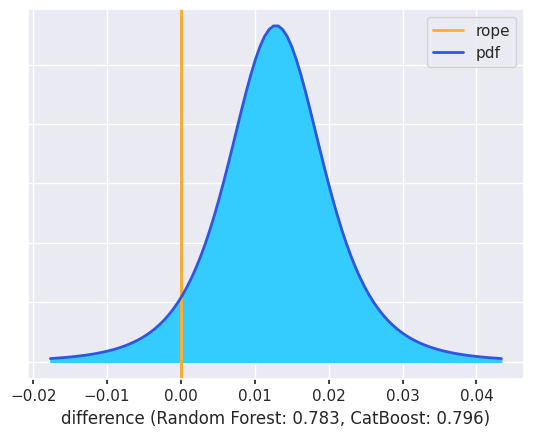

Comparación bayesiana entre Random Forest y Gradient Boosting en Recall: (0.1024766820328854, 0.8975233179671146)


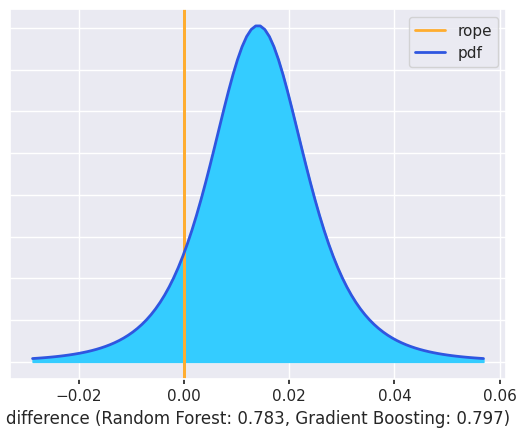

Comparación bayesiana entre Random Forest y Support Vector Classifier en Recall: (0.4678189064756595, 0.5321810935243405)


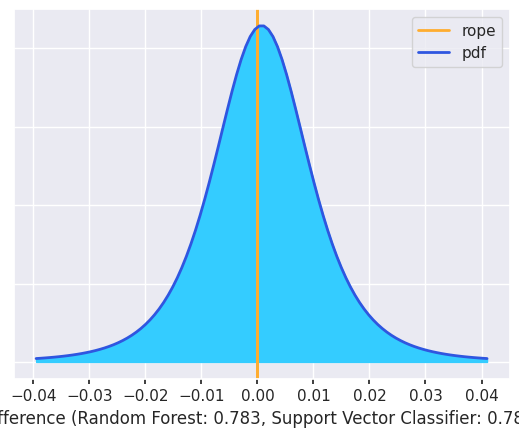

Comparación bayesiana entre Random Forest y KNN Classifier en Recall: (0.814184930241605, 0.185815069758395)


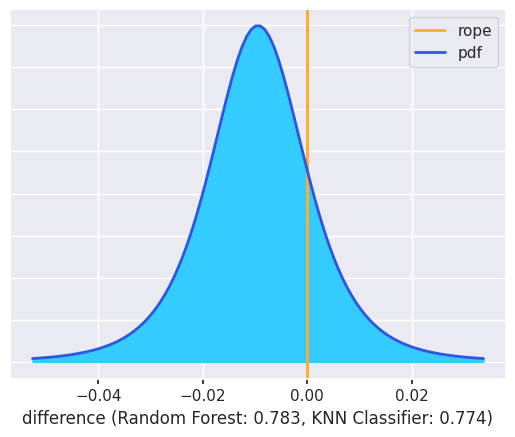

Comparación bayesiana entre Random Forest y Decision Tree en Recall: (0.9999693447294933, 3.065527050671868e-05)


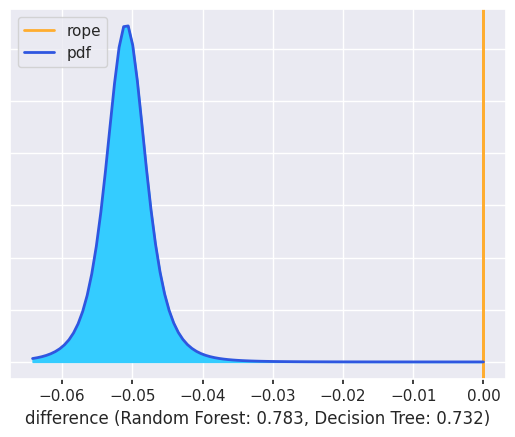

Comparación bayesiana entre Random Forest y AdaBoost en Recall: (0.33700335692481453, 0.6629966430751855)


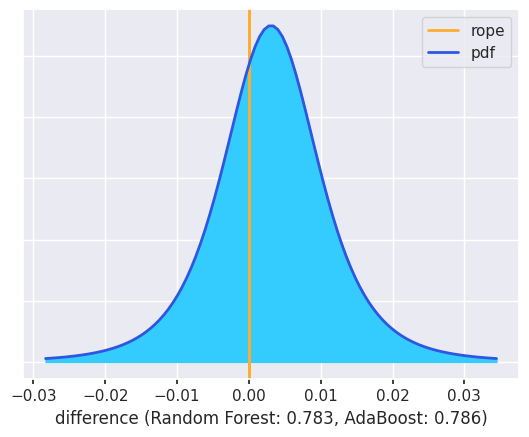

Comparación bayesiana entre Random Forest y XGBoost en Recall: (0.3440160974822237, 0.6559839025177763)


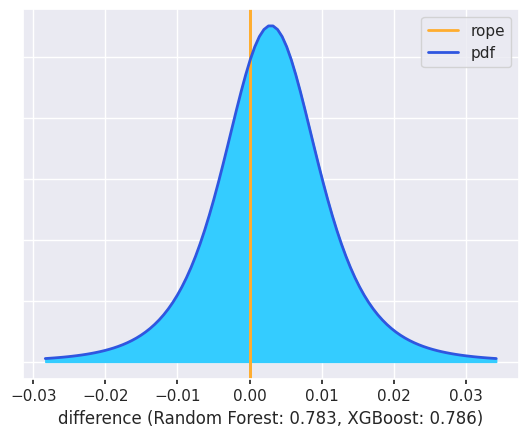

Comparación bayesiana entre Random Forest y Extra Trees en Recall: (0.9576265577426238, 0.04237344225737616)


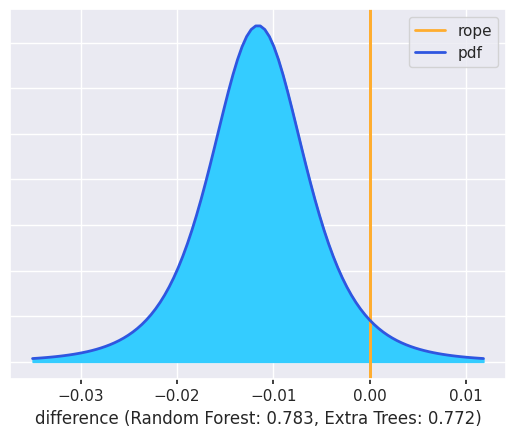

Comparación bayesiana entre CatBoost y Gradient Boosting en Recall: (0.370649115560138, 0.629350884439862)


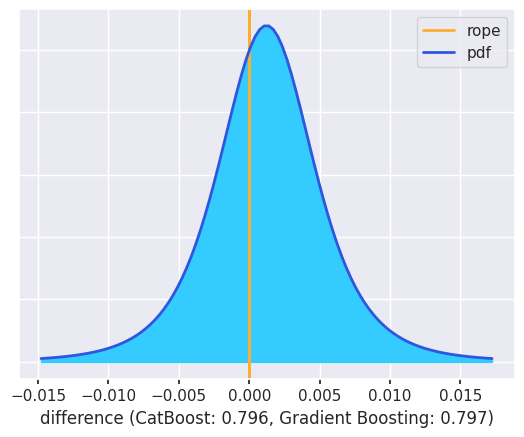

Comparación bayesiana entre CatBoost y Support Vector Classifier en Recall: (0.9869381626615943, 0.013061837338405713)


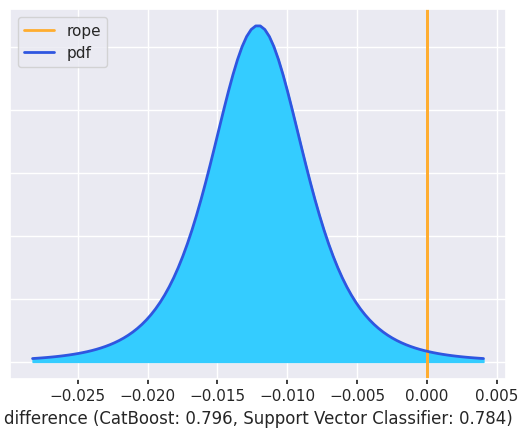

Comparación bayesiana entre CatBoost y KNN Classifier en Recall: (0.9840252938350379, 0.015974706164962105)


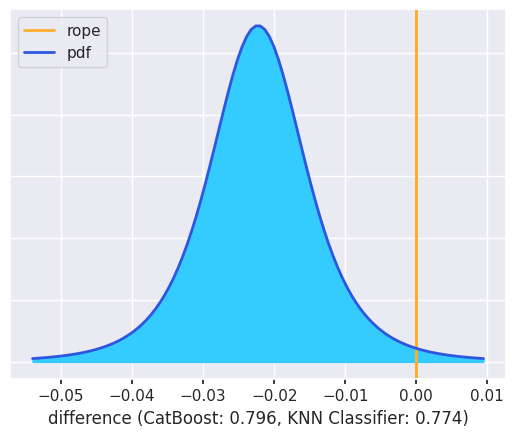

Comparación bayesiana entre CatBoost y Decision Tree en Recall: (0.9993947861233925, 0.0006052138766075021)


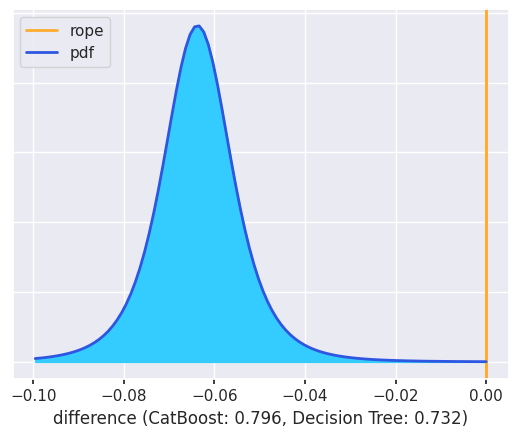

Comparación bayesiana entre CatBoost y AdaBoost en Recall: (0.9355938112120842, 0.06440618878791582)


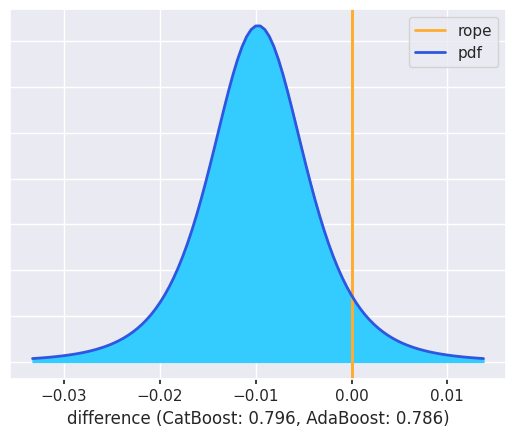

Comparación bayesiana entre CatBoost y XGBoost en Recall: (0.8838212989731543, 0.11617870102684569)


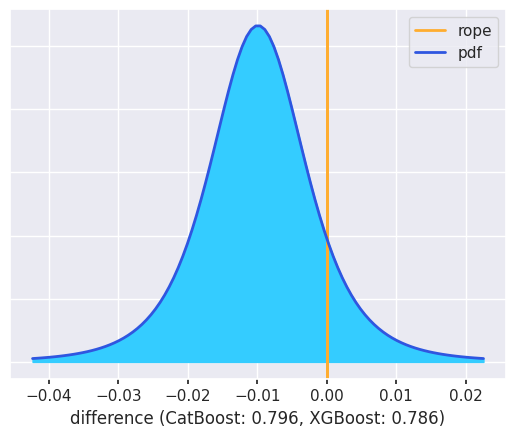

Comparación bayesiana entre CatBoost y Extra Trees en Recall: (0.9967990734499785, 0.0032009265500214656)


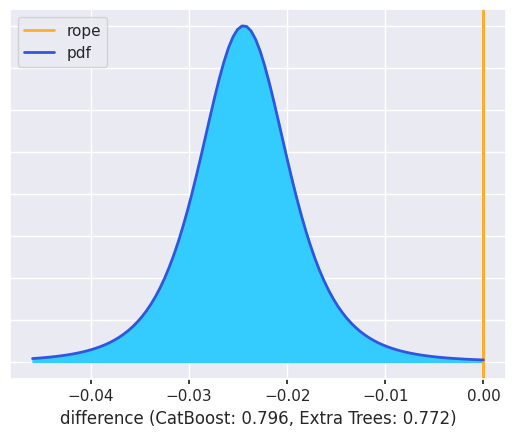

Comparación bayesiana entre Gradient Boosting y Support Vector Classifier en Recall: (0.9940377449081375, 0.005962255091862545)


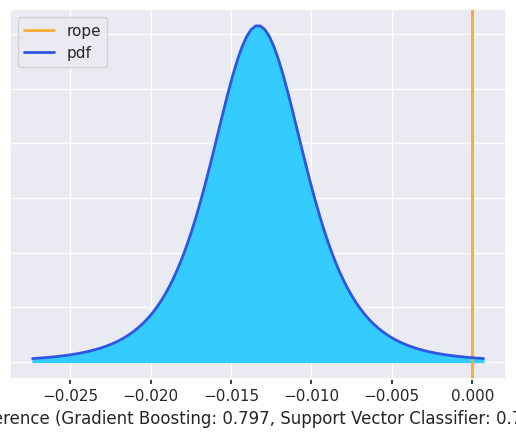

Comparación bayesiana entre Gradient Boosting y KNN Classifier en Recall: (0.9633783620062247, 0.03662163799377527)


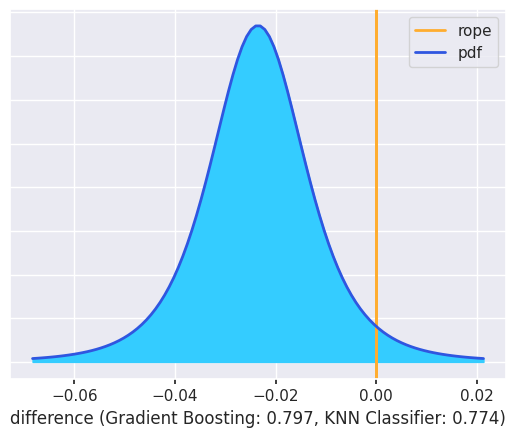

Comparación bayesiana entre Gradient Boosting y Decision Tree en Recall: (0.9986984637261654, 0.0013015362738345582)


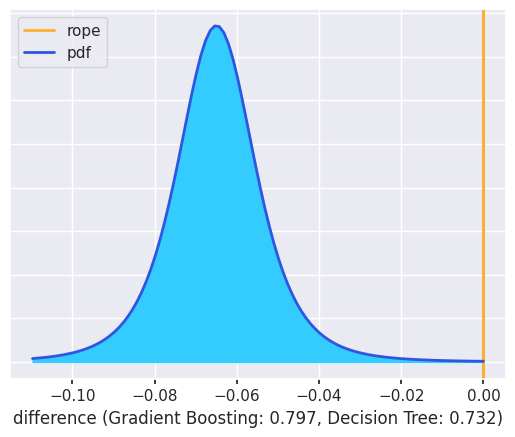

Comparación bayesiana entre Gradient Boosting y AdaBoost en Recall: (0.9540826454591134, 0.045917354540886635)


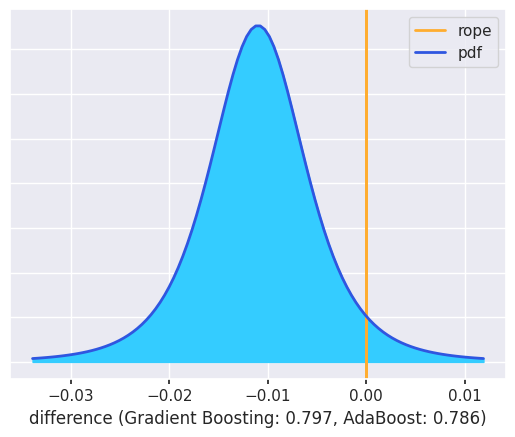

Comparación bayesiana entre Gradient Boosting y XGBoost en Recall: (0.8897346519694117, 0.1102653480305883)


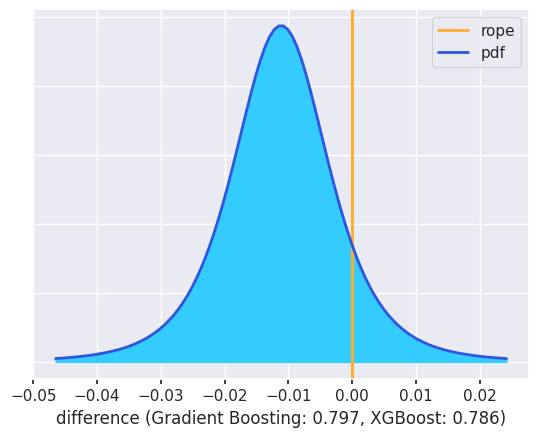

Comparación bayesiana entre Gradient Boosting y Extra Trees en Recall: (0.9896494400455818, 0.010350559954418248)


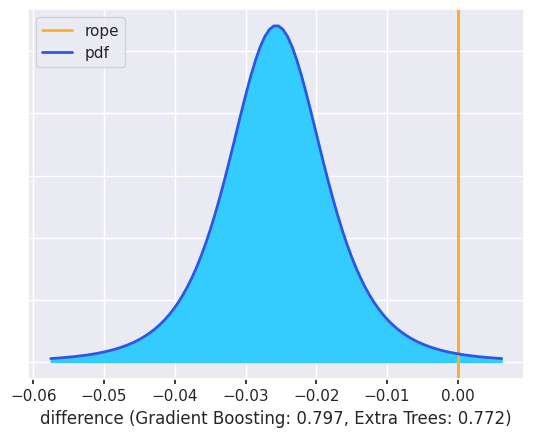

Comparación bayesiana entre Support Vector Classifier y KNN Classifier en Recall: (0.824386494570677, 0.17561350542932297)


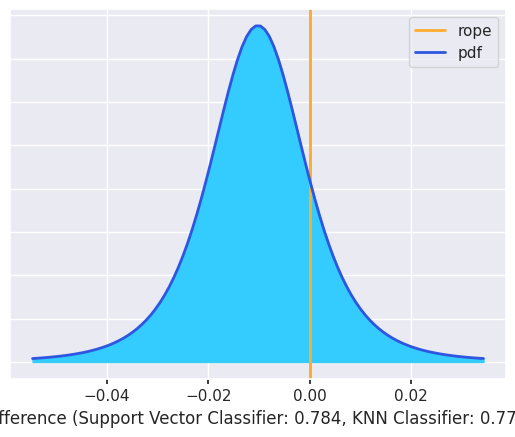

Comparación bayesiana entre Support Vector Classifier y Decision Tree en Recall: (0.9977477506730145, 0.0022522493269855337)


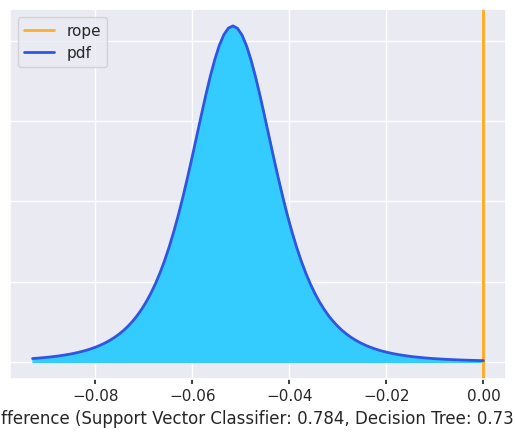

Comparación bayesiana entre Support Vector Classifier y AdaBoost en Recall: (0.3651496484154476, 0.6348503515845524)


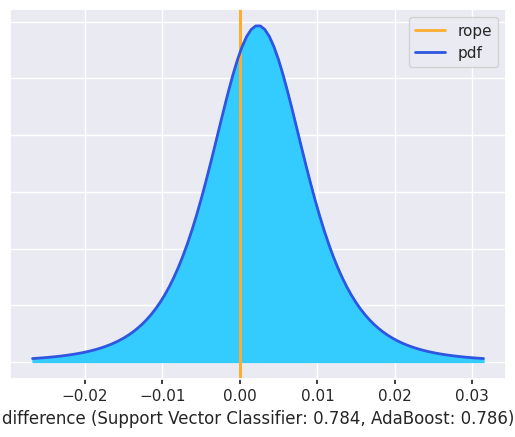

Comparación bayesiana entre Support Vector Classifier y XGBoost en Recall: (0.3750211907991937, 0.6249788092008063)


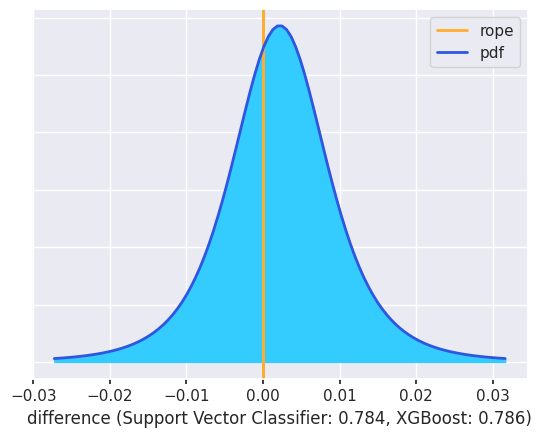

Comparación bayesiana entre Support Vector Classifier y Extra Trees en Recall: (0.954011924203233, 0.045988075796767)


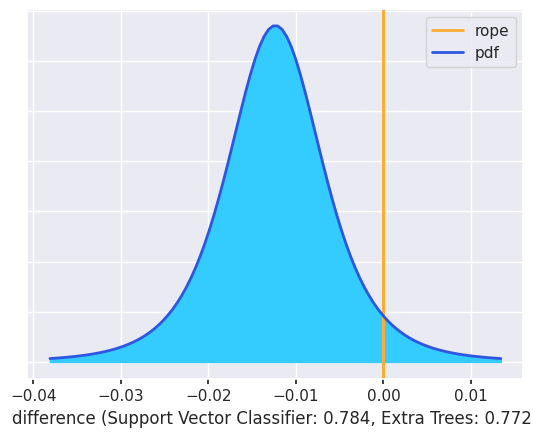

Comparación bayesiana entre KNN Classifier y Decision Tree en Recall: (0.9876888052137168, 0.012311194786283175)


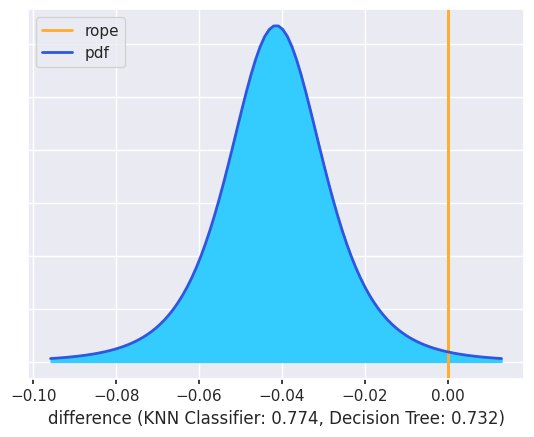

Comparación bayesiana entre KNN Classifier y AdaBoost en Recall: (0.15794834919019018, 0.8420516508098098)


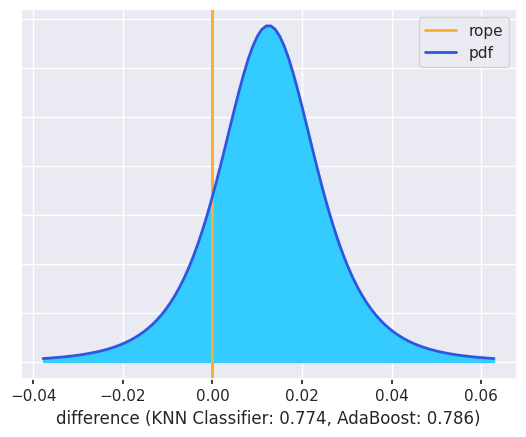

Comparación bayesiana entre KNN Classifier y XGBoost en Recall: (0.19162784949432954, 0.8083721505056705)


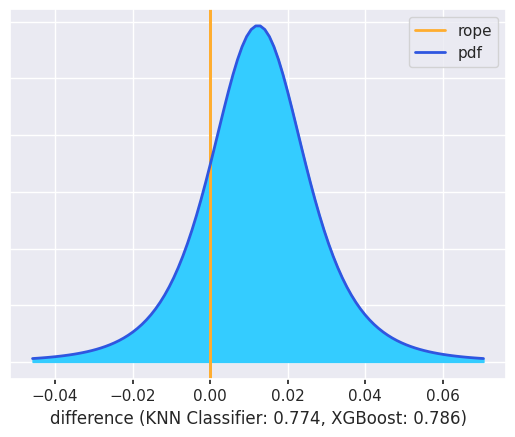

Comparación bayesiana entre KNN Classifier y Extra Trees en Recall: (0.5910678615087841, 0.4089321384912159)


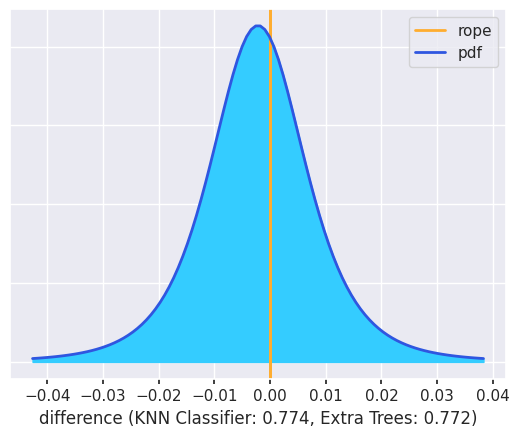

Comparación bayesiana entre Decision Tree y AdaBoost en Recall: (0.0008096147053034963, 0.9991903852946965)


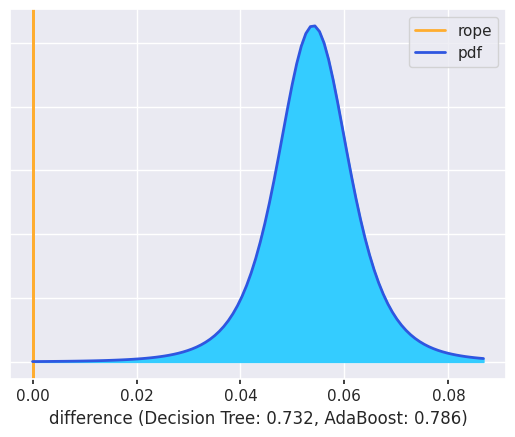

Comparación bayesiana entre Decision Tree y XGBoost en Recall: (0.0002129390745709836, 0.999787060925429)


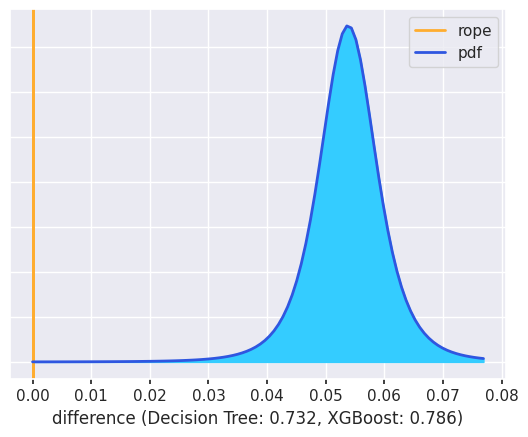

Comparación bayesiana entre Decision Tree y Extra Trees en Recall: (0.0008026856835413598, 0.9991973143164586)


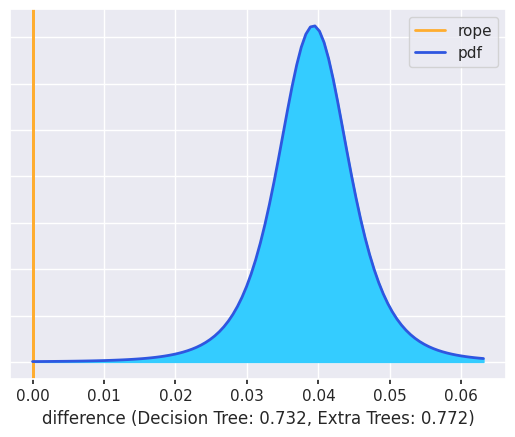

Comparación bayesiana entre AdaBoost y XGBoost en Recall: (0.5077605442894492, 0.49223945571055083)


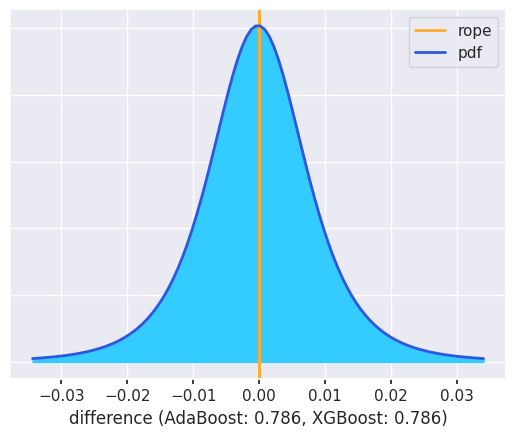

Comparación bayesiana entre AdaBoost y Extra Trees en Recall: (0.9413195307028308, 0.05868046929716919)


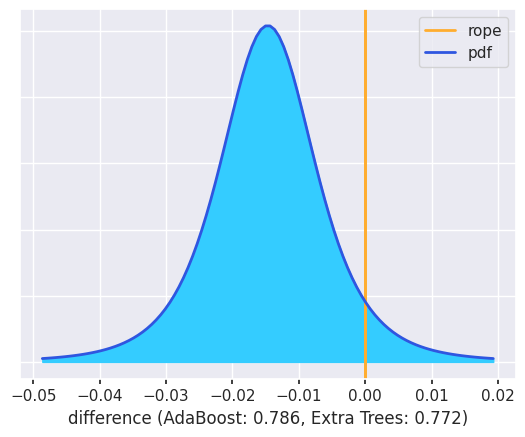

Comparación bayesiana entre XGBoost y Extra Trees en Recall: (0.9884998358808998, 0.011500164119100154)


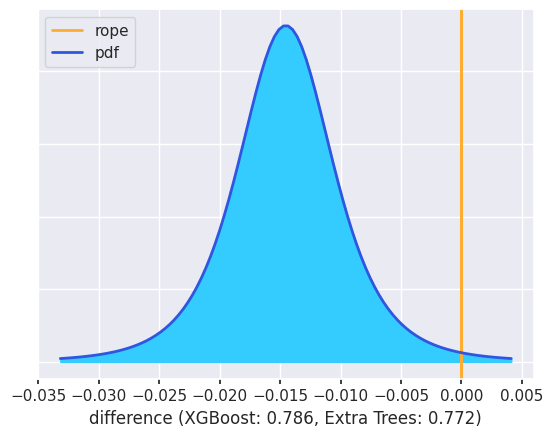

Comparación bayesiana entre Random Forest y CatBoost en Precision: (0.07768586390648513, 0.9223141360935149)


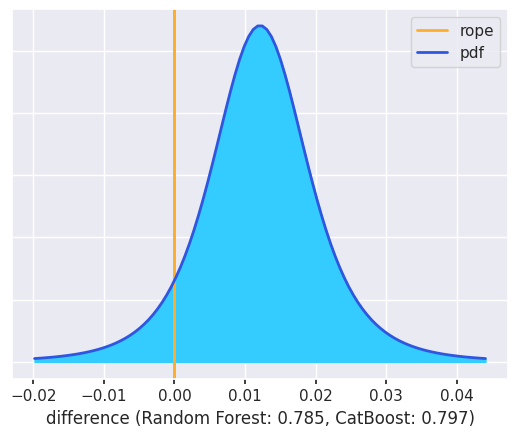

Comparación bayesiana entre Random Forest y Gradient Boosting en Precision: (0.09166821175469964, 0.9083317882453004)


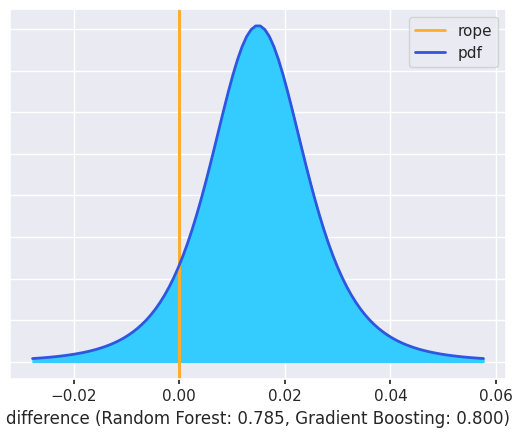

Comparación bayesiana entre Random Forest y Support Vector Classifier en Precision: (0.1708721213950083, 0.8291278786049917)


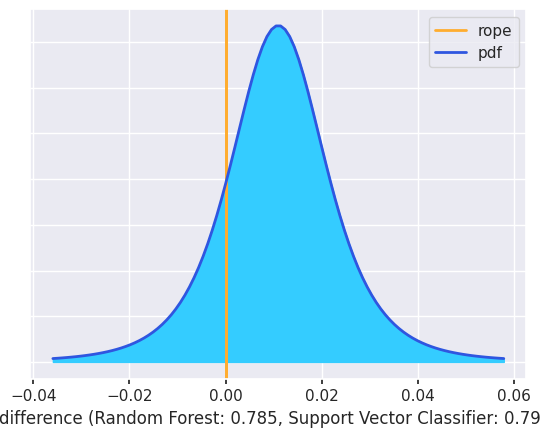

Comparación bayesiana entre Random Forest y KNN Classifier en Precision: (0.830447088451977, 0.169552911548023)


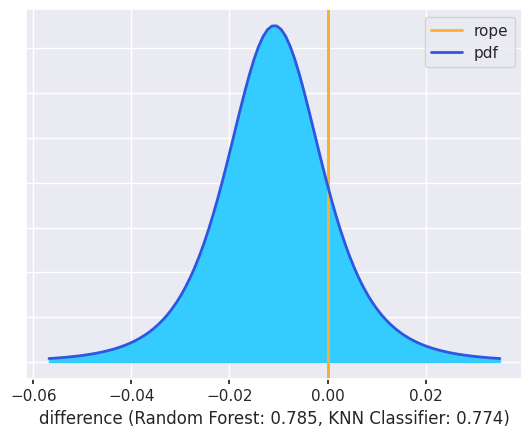

Comparación bayesiana entre Random Forest y Decision Tree en Precision: (0.9999813717320082, 1.862826799181594e-05)


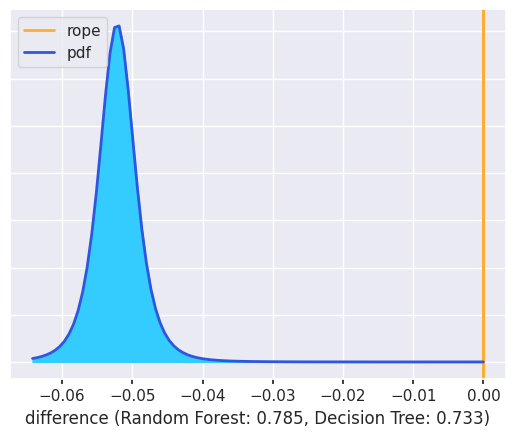

Comparación bayesiana entre Random Forest y AdaBoost en Precision: (0.3370715723932296, 0.6629284276067704)


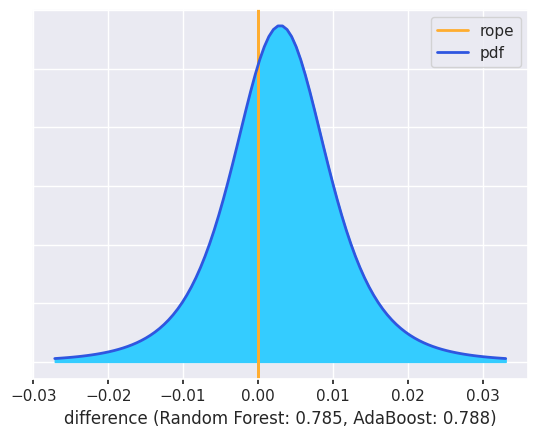

Comparación bayesiana entre Random Forest y XGBoost en Precision: (0.3975978637542582, 0.6024021362457418)


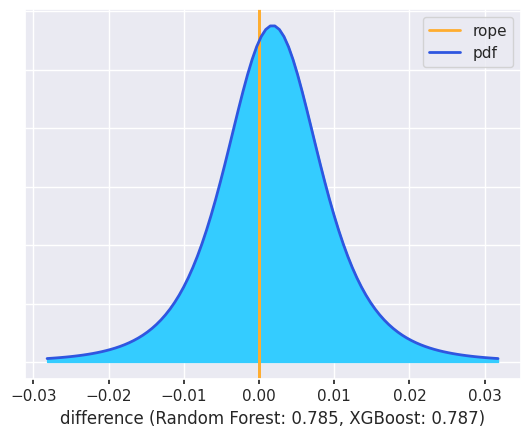

Comparación bayesiana entre Random Forest y Extra Trees en Precision: (0.9542116904439176, 0.045788309556082374)


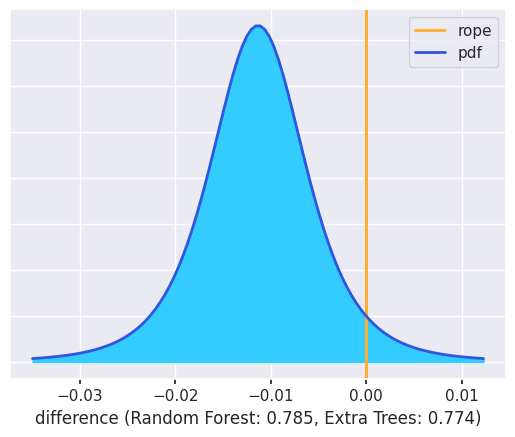

Comparación bayesiana entre CatBoost y Gradient Boosting en Precision: (0.21770813368095765, 0.7822918663190424)


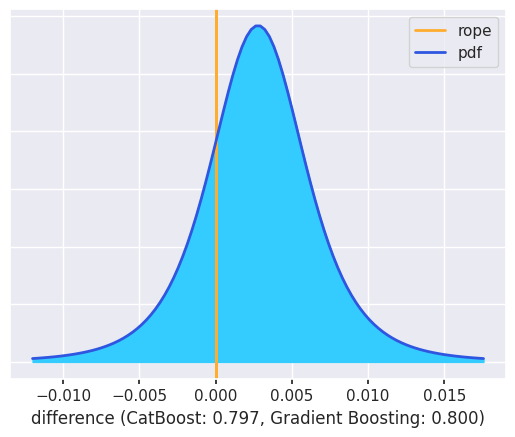

Comparación bayesiana entre CatBoost y Support Vector Classifier en Precision: (0.6048535775808677, 0.39514642241913234)


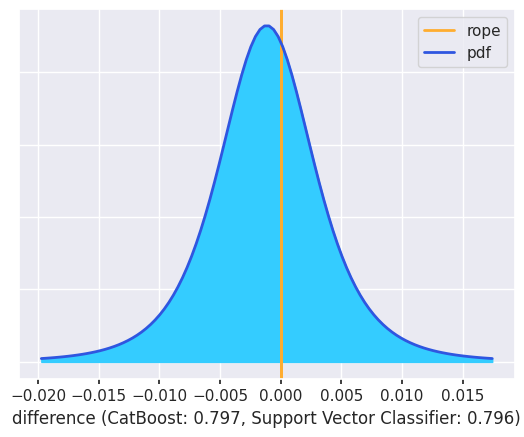

Comparación bayesiana entre CatBoost y KNN Classifier en Precision: (0.9874754572803839, 0.012524542719616116)


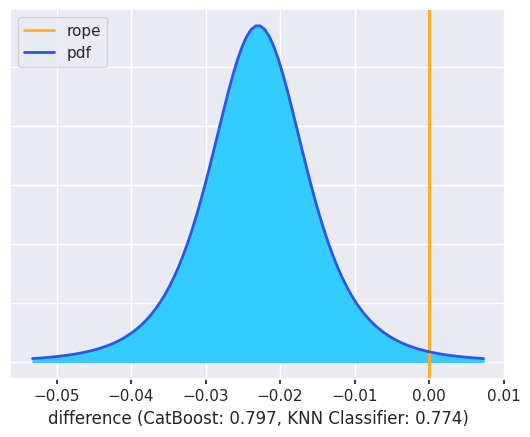

Comparación bayesiana entre CatBoost y Decision Tree en Precision: (0.9993464701463632, 0.0006535298536367584)


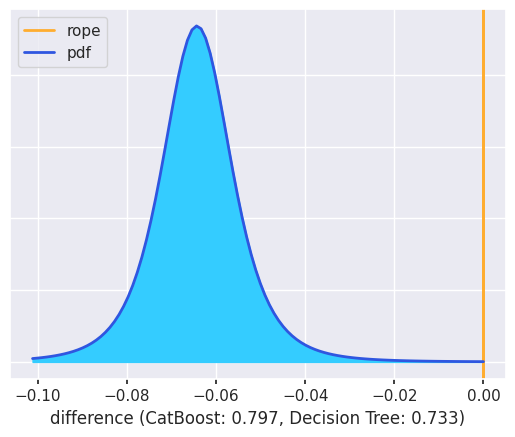

Comparación bayesiana entre CatBoost y AdaBoost en Precision: (0.9351360462301711, 0.0648639537698289)


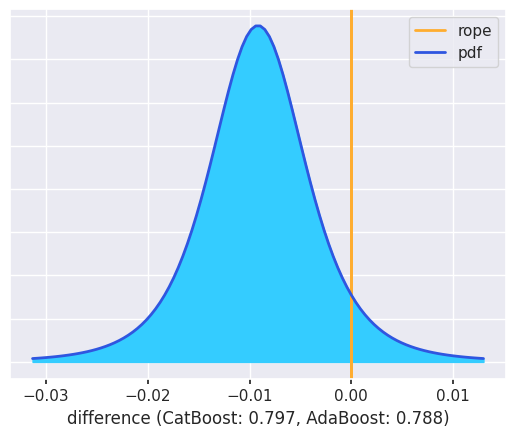

Comparación bayesiana entre CatBoost y XGBoost en Precision: (0.8875169569732588, 0.11248304302674117)


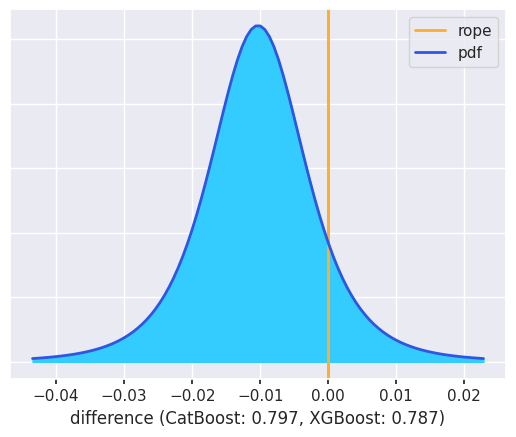

Comparación bayesiana entre CatBoost y Extra Trees en Precision: (0.995945263483555, 0.004054736516444946)


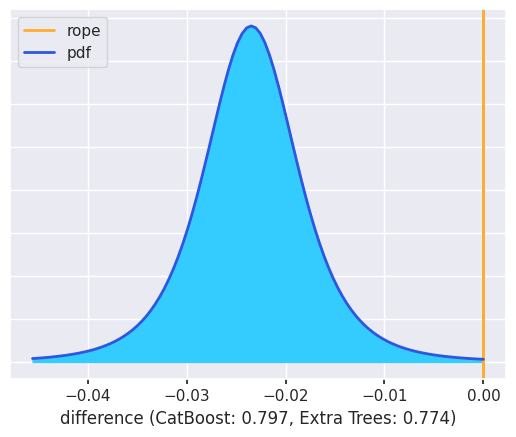

Comparación bayesiana entre Gradient Boosting y Support Vector Classifier en Precision: (0.8107475715118793, 0.18925242848812074)


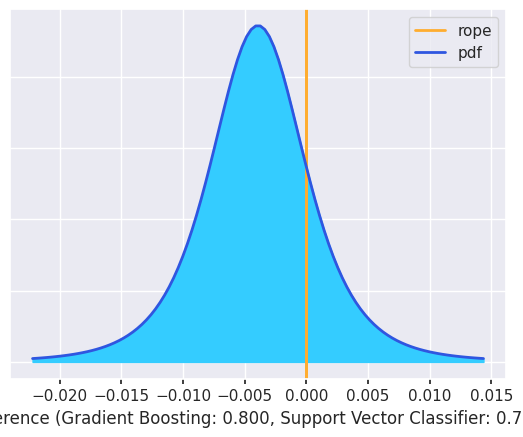

Comparación bayesiana entre Gradient Boosting y KNN Classifier en Precision: (0.9761639858456477, 0.023836014154352325)


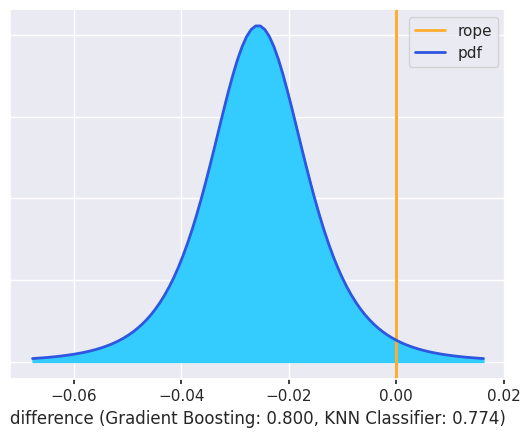

Comparación bayesiana entre Gradient Boosting y Decision Tree en Precision: (0.9987729466636199, 0.0012270533363800684)


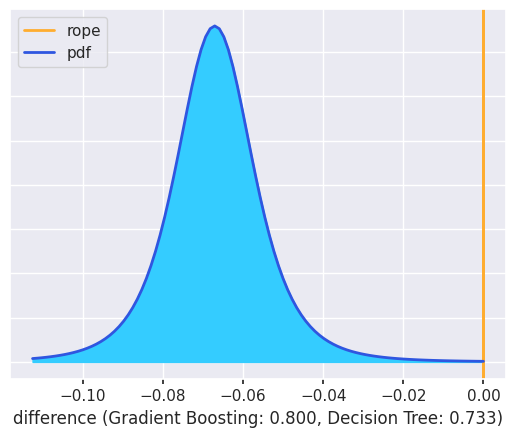

Comparación bayesiana entre Gradient Boosting y AdaBoost en Precision: (0.9652371525085073, 0.03476284749149272)


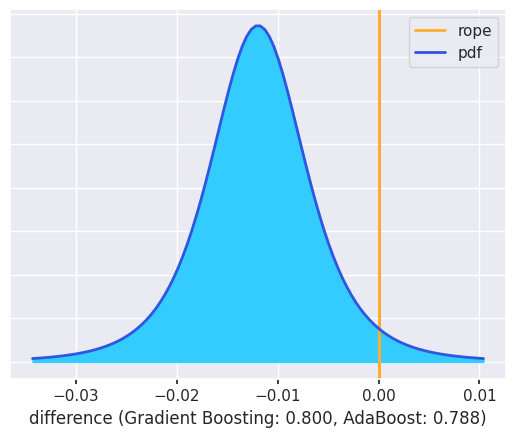

Comparación bayesiana entre Gradient Boosting y XGBoost en Precision: (0.9159787240517158, 0.08402127594828424)


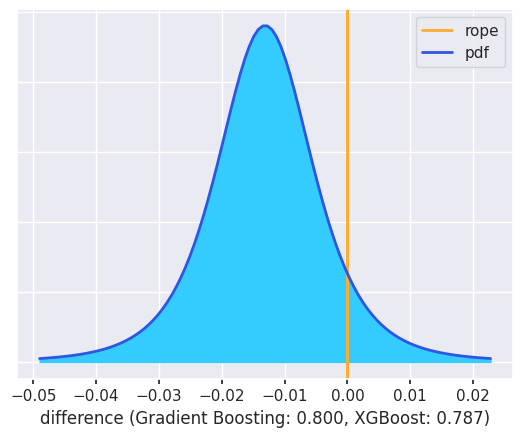

Comparación bayesiana entre Gradient Boosting y Extra Trees en Precision: (0.9916647932549334, 0.008335206745066603)


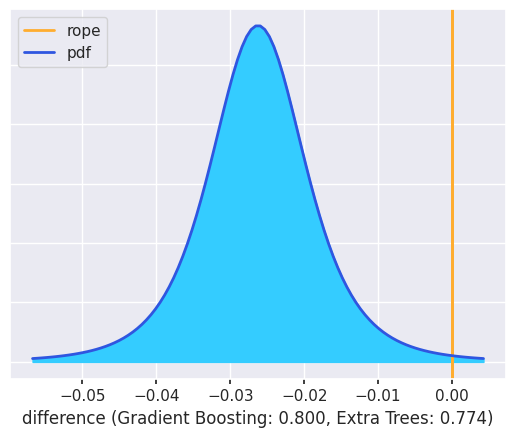

Comparación bayesiana entre Support Vector Classifier y KNN Classifier en Precision: (0.9745659170829798, 0.025434082917020207)


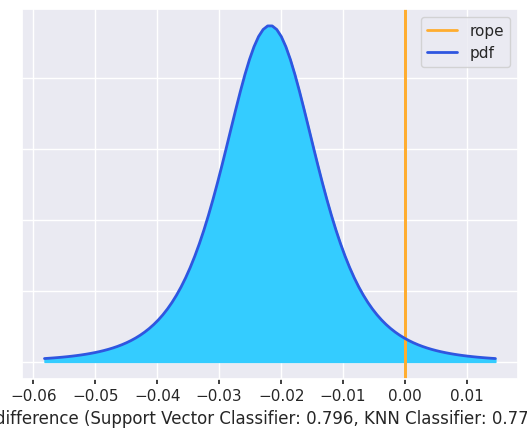

Comparación bayesiana entre Support Vector Classifier y Decision Tree en Precision: (0.99771744935521, 0.0022825506447899935)


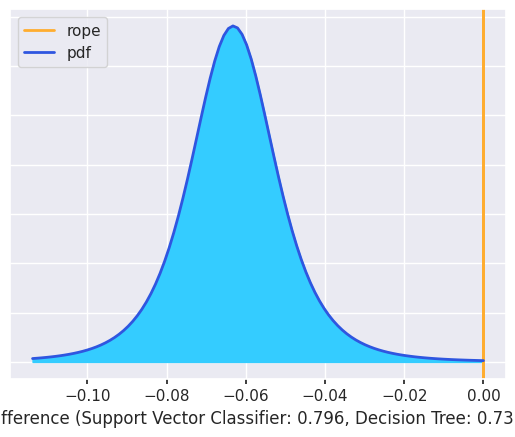

Comparación bayesiana entre Support Vector Classifier y AdaBoost en Precision: (0.8126599912411111, 0.1873400087588889)


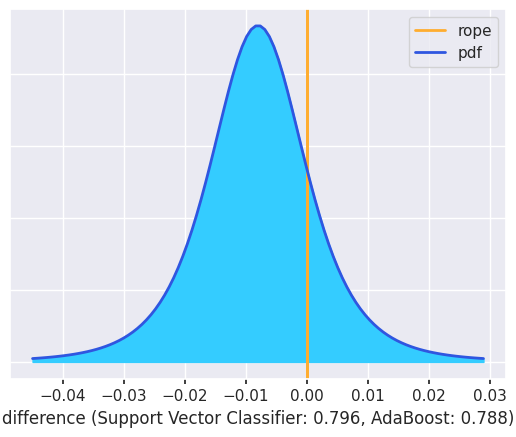

Comparación bayesiana entre Support Vector Classifier y XGBoost en Precision: (0.8271823706078576, 0.1728176293921424)


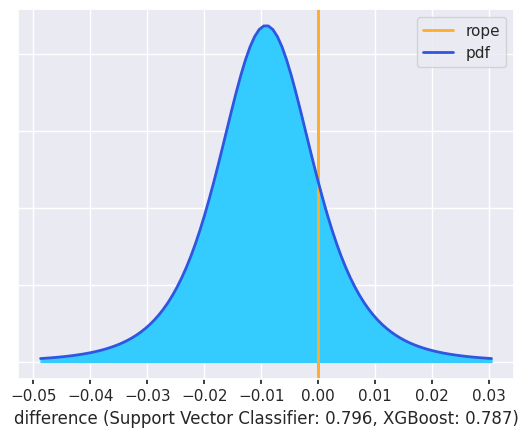

Comparación bayesiana entre Support Vector Classifier y Extra Trees en Precision: (0.9872135257179134, 0.012786474282086568)


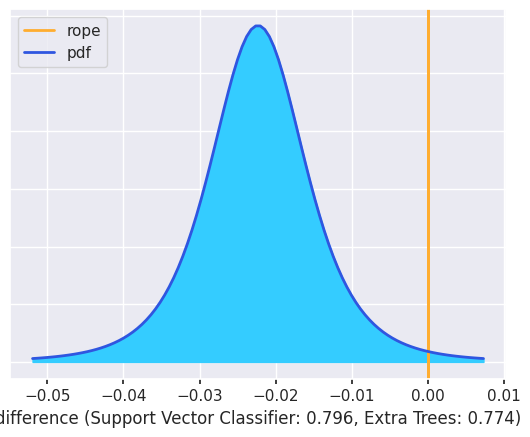

Comparación bayesiana entre KNN Classifier y Decision Tree en Precision: (0.9875466499414405, 0.01245335005855952)


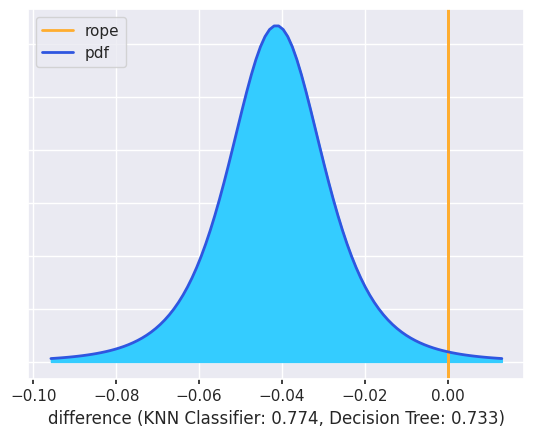

Comparación bayesiana entre KNN Classifier y AdaBoost en Precision: (0.12666108233784934, 0.8733389176621507)


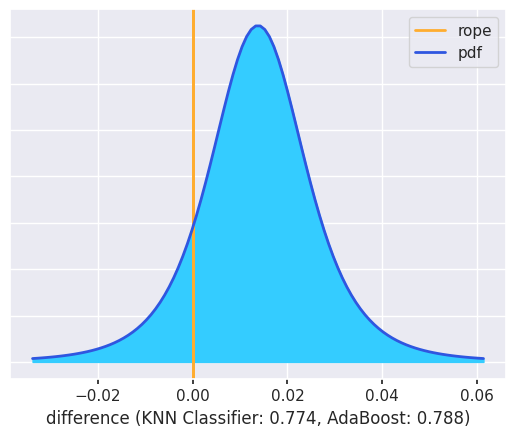

Comparación bayesiana entre KNN Classifier y XGBoost en Precision: (0.186962261575485, 0.813037738424515)


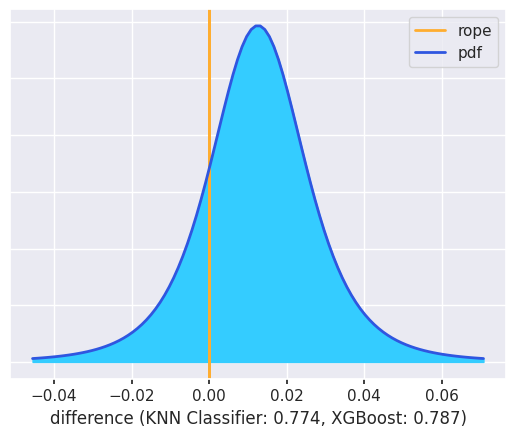

Comparación bayesiana entre KNN Classifier y Extra Trees en Precision: (0.5204087837713193, 0.47959121622868073)


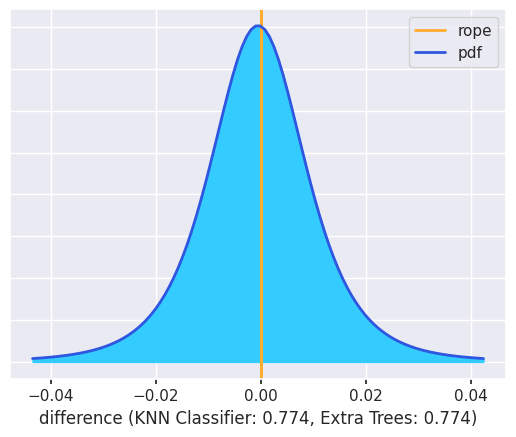

Comparación bayesiana entre Decision Tree y AdaBoost en Precision: (0.0007868010036439221, 0.9992131989963561)


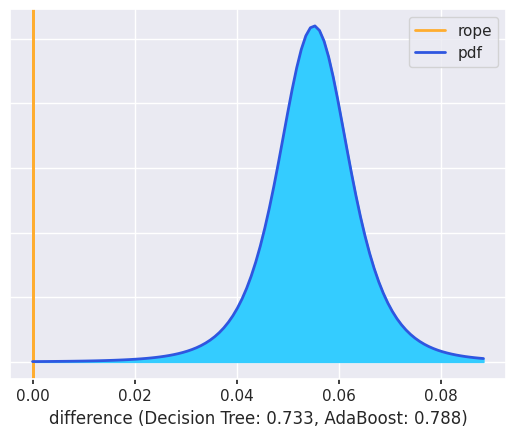

Comparación bayesiana entre Decision Tree y XGBoost en Precision: (0.000222661670884583, 0.9997773383291154)


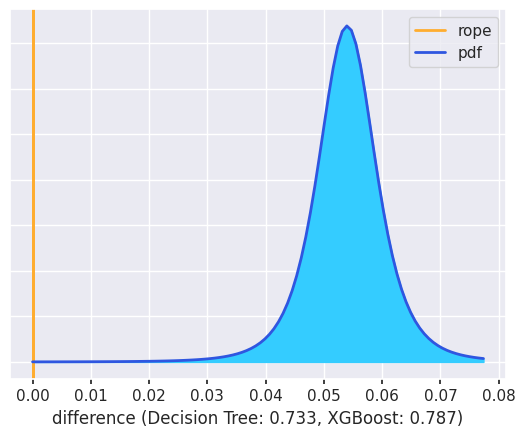

Comparación bayesiana entre Decision Tree y Extra Trees en Precision: (0.0006428490054235514, 0.9993571509945764)


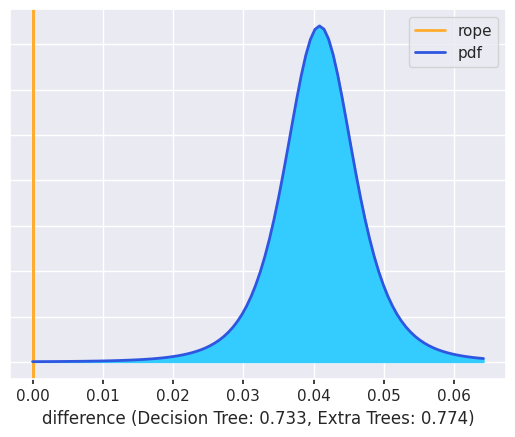

Comparación bayesiana entre AdaBoost y XGBoost en Precision: (0.5588292753802543, 0.4411707246197457)


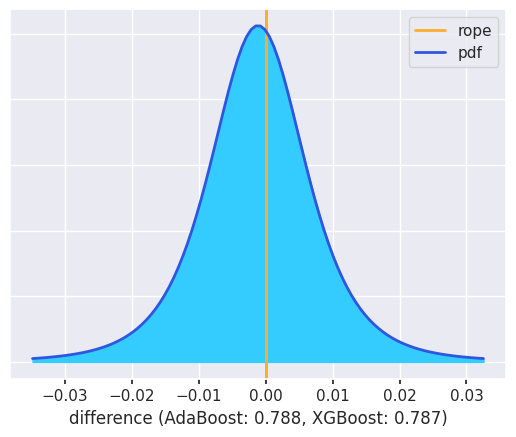

Comparación bayesiana entre AdaBoost y Extra Trees en Precision: (0.9480322576118898, 0.051967742388110194)


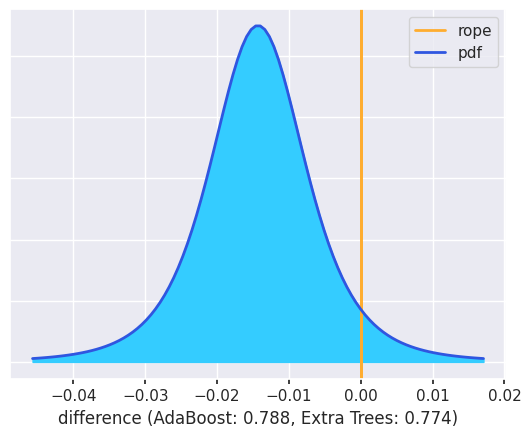

Comparación bayesiana entre XGBoost y Extra Trees en Precision: (0.989920412841446, 0.010079587158553949)


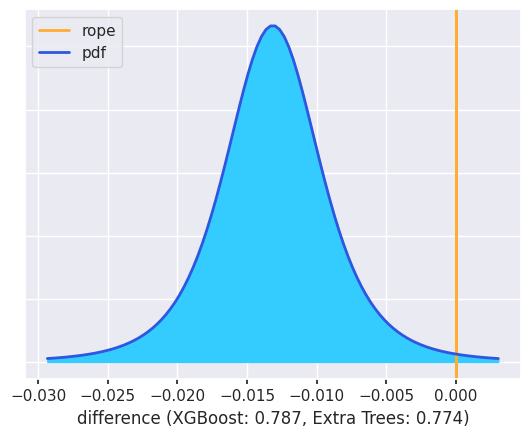

Comparación bayesiana entre Random Forest y CatBoost en F1 score: (0.057072272130335056, 0.9429277278696649)


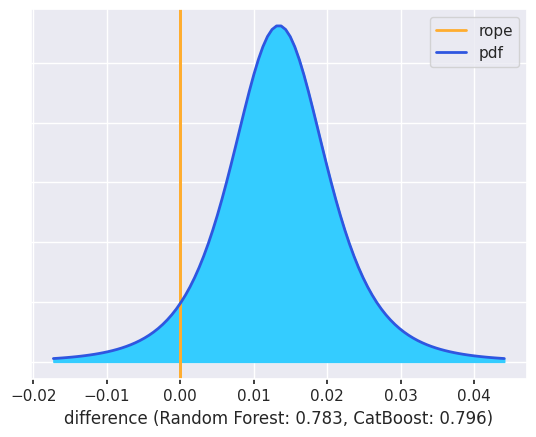

Comparación bayesiana entre Random Forest y Gradient Boosting en F1 score: (0.09841669773127881, 0.9015833022687212)


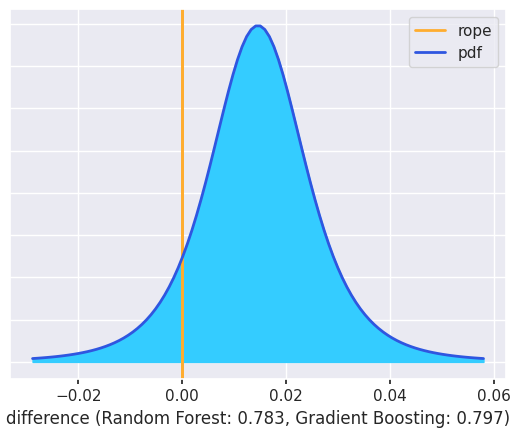

Comparación bayesiana entre Random Forest y Support Vector Classifier en F1 score: (0.5046612038597456, 0.49533879614025444)


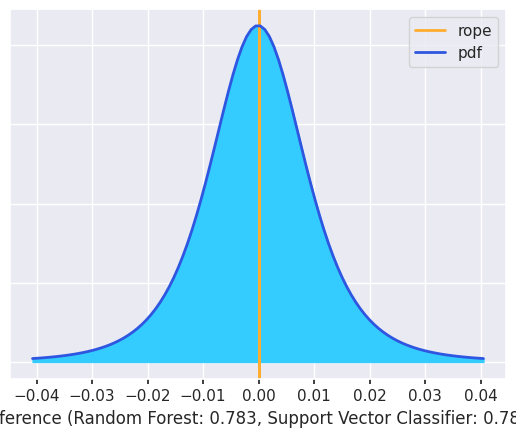

Comparación bayesiana entre Random Forest y KNN Classifier en F1 score: (0.8027738999655394, 0.19722610003446062)


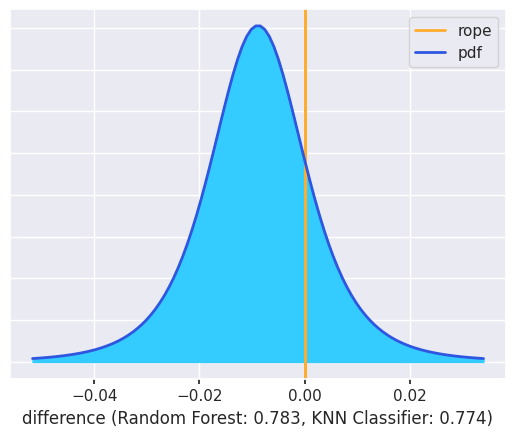

Comparación bayesiana entre Random Forest y Decision Tree en F1 score: (0.9999630256348937, 3.697436510630148e-05)


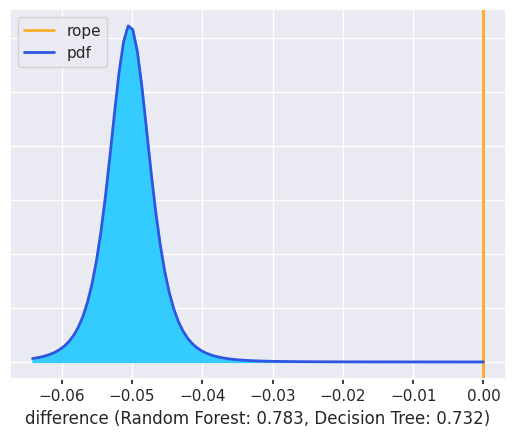

Comparación bayesiana entre Random Forest y AdaBoost en F1 score: (0.31438183412028076, 0.6856181658797192)


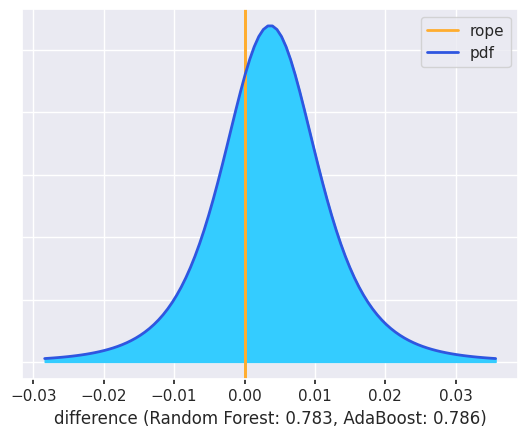

Comparación bayesiana entre Random Forest y XGBoost en F1 score: (0.321695123594275, 0.678304876405725)


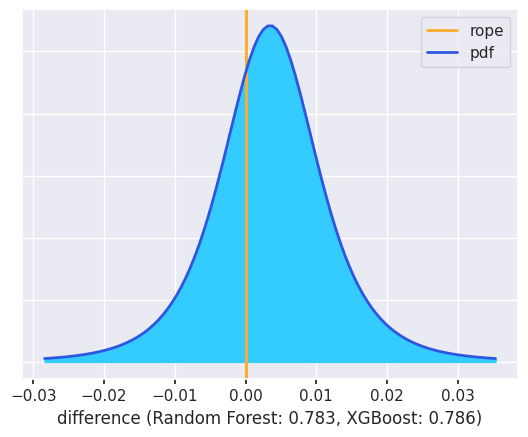

Comparación bayesiana entre Random Forest y Extra Trees en F1 score: (0.9588771243080129, 0.04112287569198714)


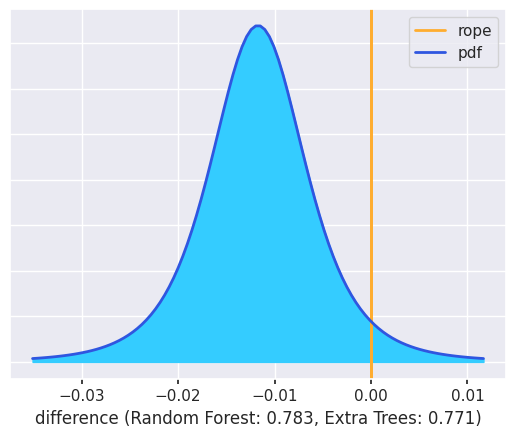

Comparación bayesiana entre CatBoost y Gradient Boosting en F1 score: (0.38277704565542403, 0.617222954344576)


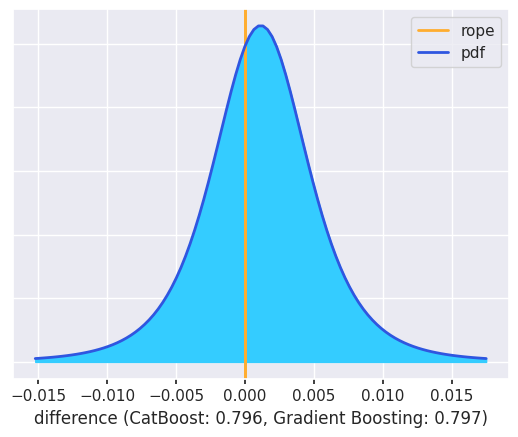

Comparación bayesiana entre CatBoost y Support Vector Classifier en F1 score: (0.989348339946914, 0.010651660053086043)


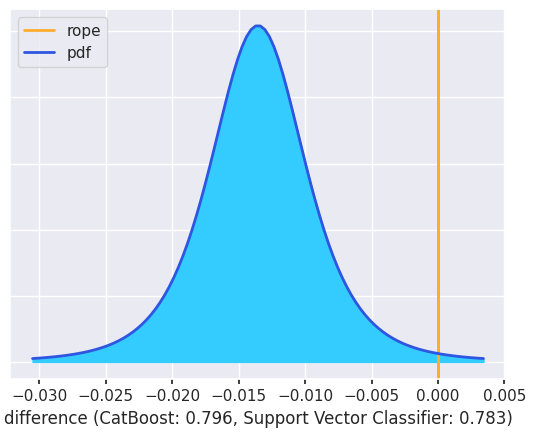

Comparación bayesiana entre CatBoost y KNN Classifier en F1 score: (0.9835868957289287, 0.016413104271071344)


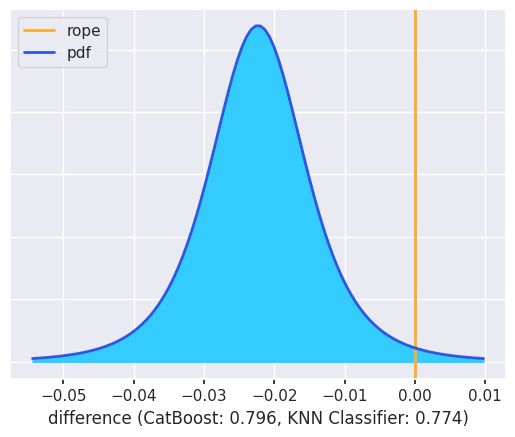

Comparación bayesiana entre CatBoost y Decision Tree en F1 score: (0.9993971863524682, 0.0006028136475317858)


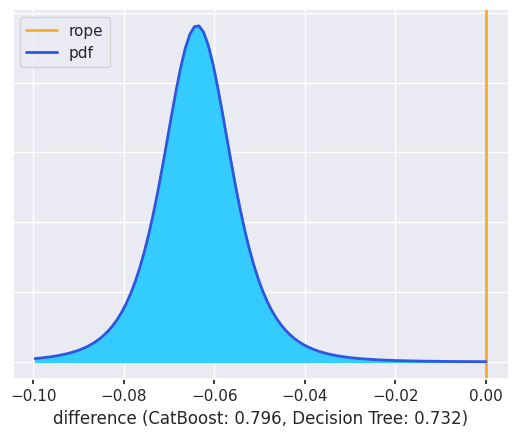

Comparación bayesiana entre CatBoost y AdaBoost en F1 score: (0.9342935766245108, 0.06570642337548915)


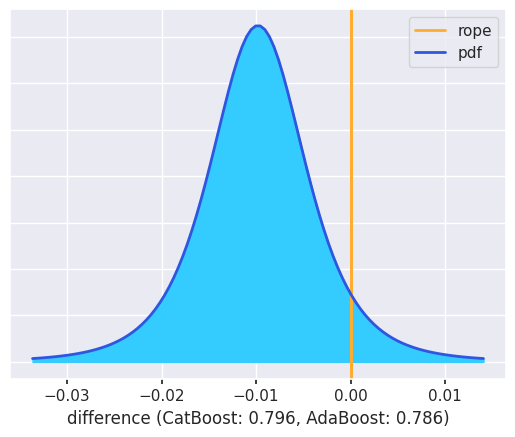

Comparación bayesiana entre CatBoost y XGBoost en F1 score: (0.8853986512266969, 0.11460134877330308)


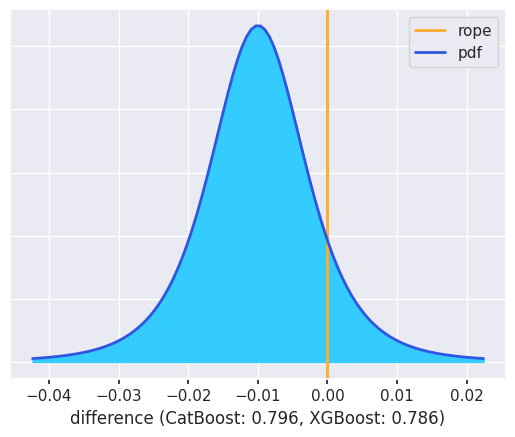

Comparación bayesiana entre CatBoost y Extra Trees en F1 score: (0.9970319229660067, 0.002968077033993266)


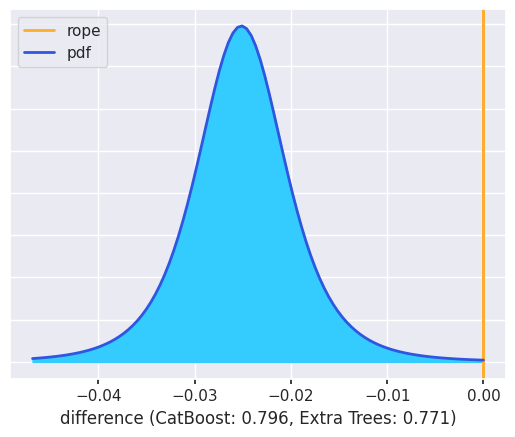

Comparación bayesiana entre Gradient Boosting y Support Vector Classifier en F1 score: (0.9958362799781576, 0.004163720021842399)


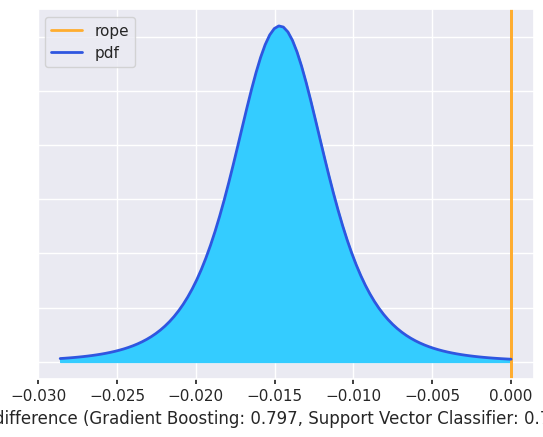

Comparación bayesiana entre Gradient Boosting y KNN Classifier en F1 score: (0.961629620537216, 0.03837037946278399)


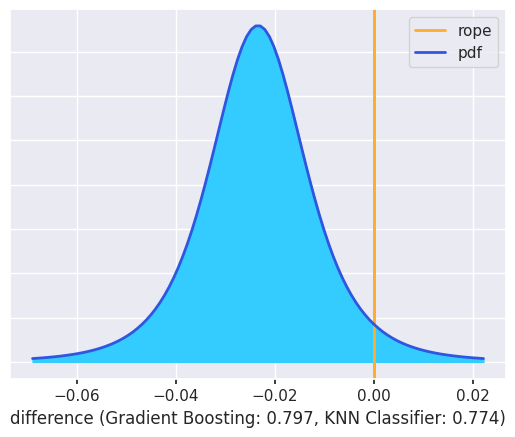

Comparación bayesiana entre Gradient Boosting y Decision Tree en F1 score: (0.9986791493933466, 0.0013208506066534342)


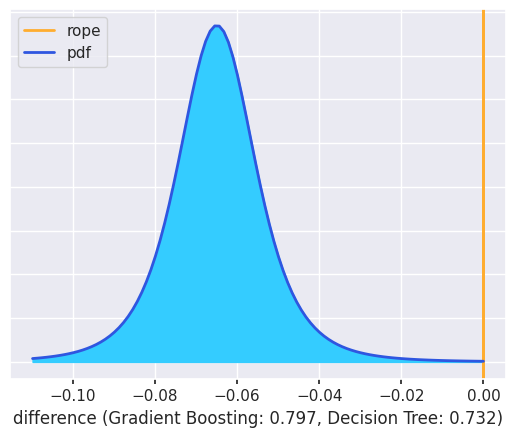

Comparación bayesiana entre Gradient Boosting y AdaBoost en F1 score: (0.9529447839745456, 0.04705521602545437)


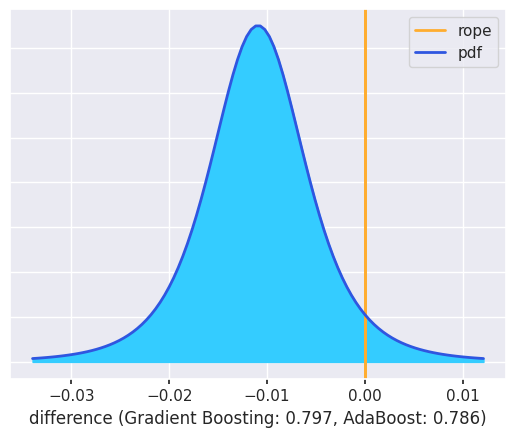

Comparación bayesiana entre Gradient Boosting y XGBoost en F1 score: (0.8887893143584695, 0.11121068564153047)


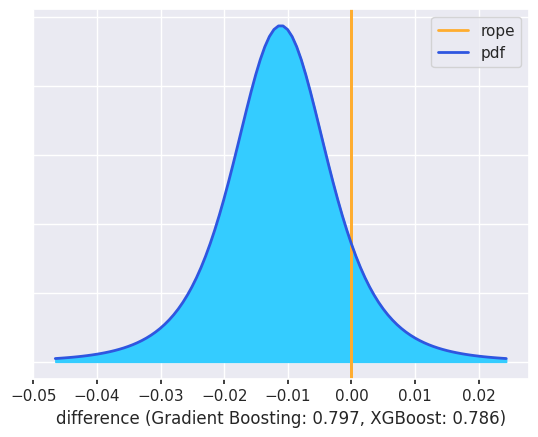

Comparación bayesiana entre Gradient Boosting y Extra Trees en F1 score: (0.989770526109404, 0.01022947389059603)


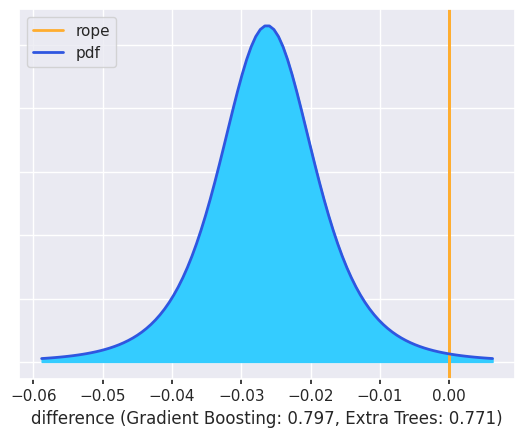

Comparación bayesiana entre Support Vector Classifier y KNN Classifier en F1 score: (0.7829594340754251, 0.21704056592457488)


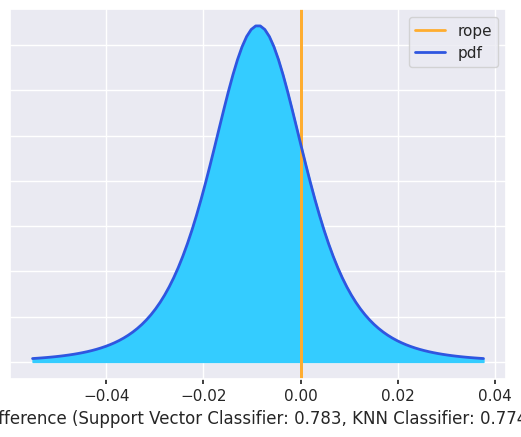

Comparación bayesiana entre Support Vector Classifier y Decision Tree en F1 score: (0.9976490652844375, 0.0023509347155624694)


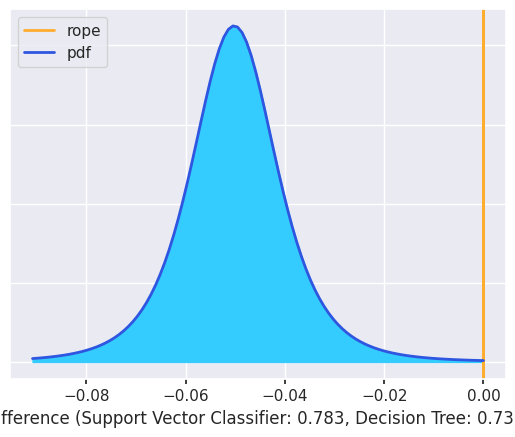

Comparación bayesiana entre Support Vector Classifier y AdaBoost en F1 score: (0.28619933902551964, 0.7138006609744804)


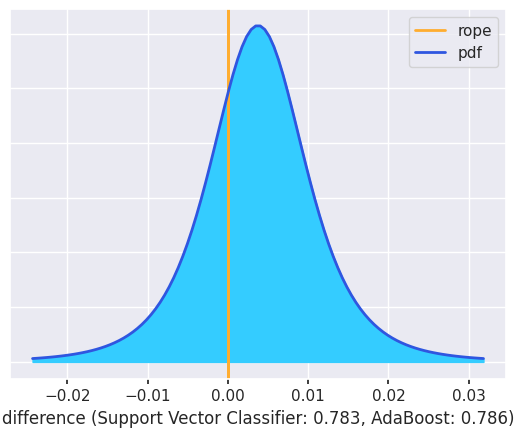

Comparación bayesiana entre Support Vector Classifier y XGBoost en F1 score: (0.2981649055809783, 0.7018350944190217)


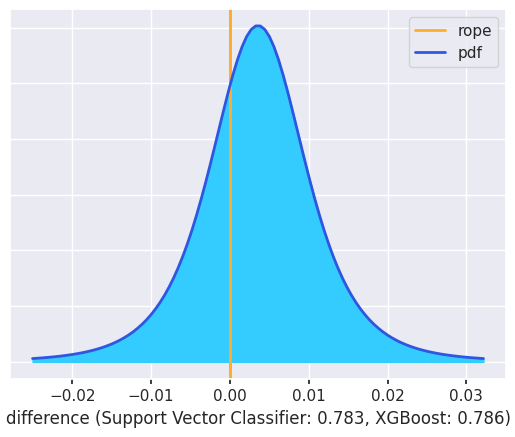

Comparación bayesiana entre Support Vector Classifier y Extra Trees en F1 score: (0.9407504370644394, 0.05924956293556061)


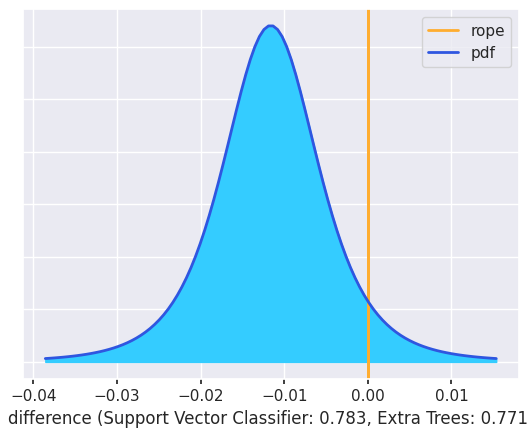

Comparación bayesiana entre KNN Classifier y Decision Tree en F1 score: (0.9876271403121296, 0.012372859687870386)


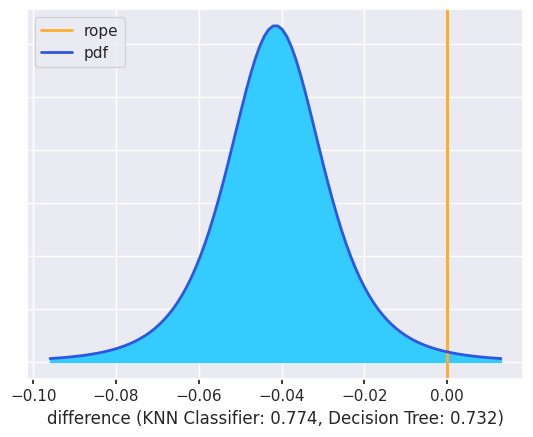

Comparación bayesiana entre KNN Classifier y AdaBoost en F1 score: (0.16093961364826215, 0.8390603863517379)


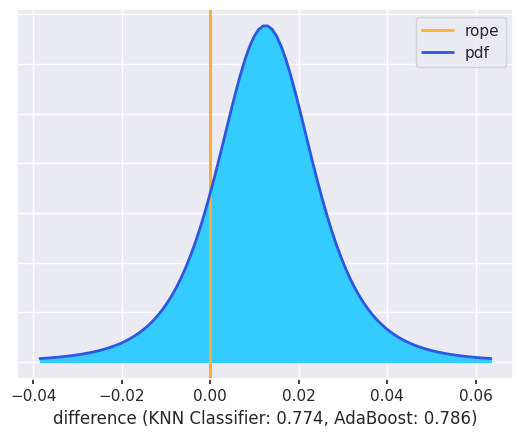

Comparación bayesiana entre KNN Classifier y XGBoost en F1 score: (0.192549068946561, 0.807450931053439)


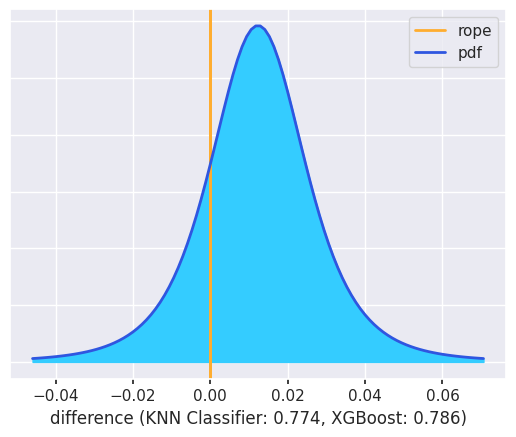

Comparación bayesiana entre KNN Classifier y Extra Trees en F1 score: (0.6199073994583169, 0.38009260054168315)


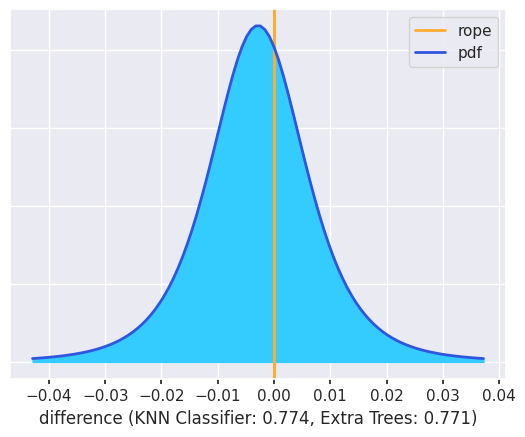

Comparación bayesiana entre Decision Tree y AdaBoost en F1 score: (0.0008129397788019244, 0.9991870602211981)


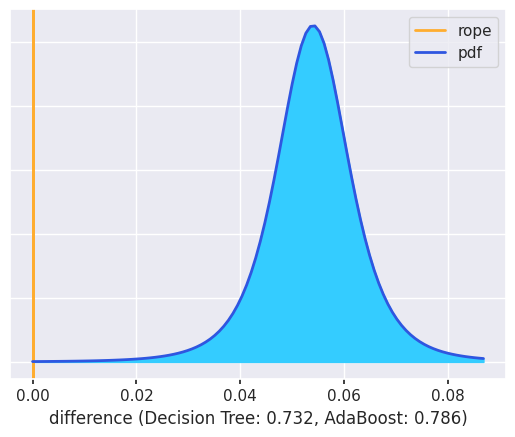

Comparación bayesiana entre Decision Tree y XGBoost en F1 score: (0.00022207989997380384, 0.9997779201000262)


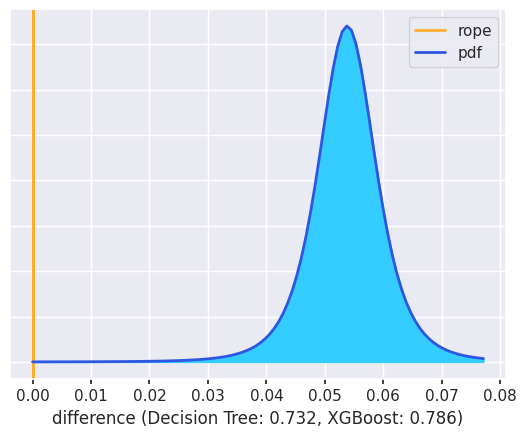

Comparación bayesiana entre Decision Tree y Extra Trees en F1 score: (0.0008941030675682082, 0.9991058969324318)


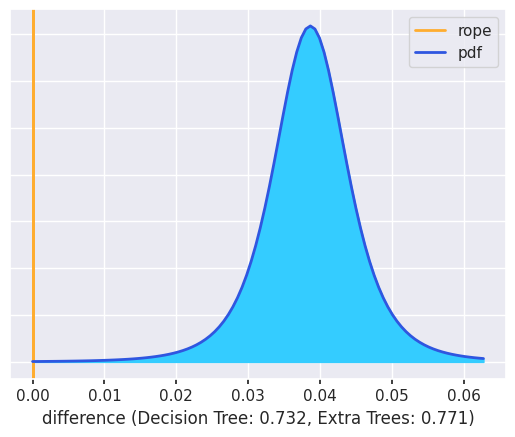

Comparación bayesiana entre AdaBoost y XGBoost en F1 score: (0.5088340834459688, 0.4911659165540312)


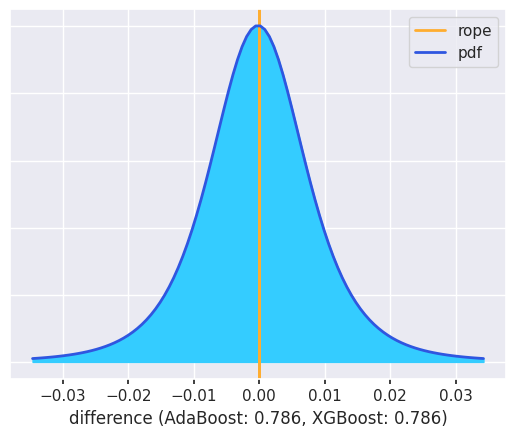

Comparación bayesiana entre AdaBoost y Extra Trees en F1 score: (0.944948958726261, 0.055051041273739054)


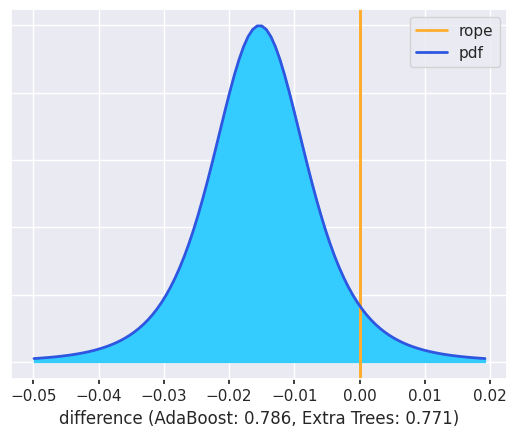

Comparación bayesiana entre XGBoost y Extra Trees en F1 score: (0.9889703257758561, 0.011029674224143915)


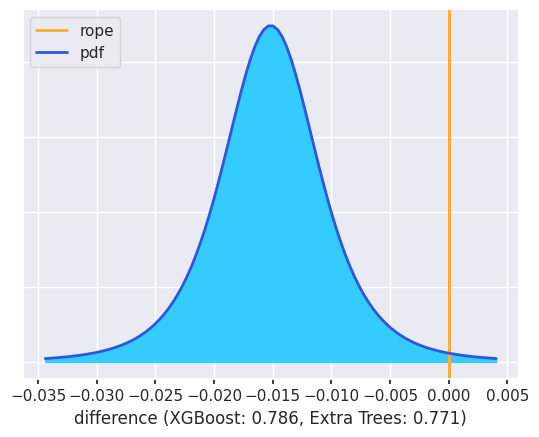

In [ ]:
# 6. Comparación bayesiana de todos los clasificadores ------------------------------------------------------------------------------------------------
# Función para realizar comparaciones bayesianas entre todos los pares de modelos y generar gráficos
def comparaciones_bayesianas(df, nombre_metrica):
    rope = 0.0                                          # Región de Equivalencia Práctica (ROPE)
    bayes_comparison_results = {}

    # Comparar todos los pares únicos de modelos
    for i, modelo_1 in enumerate(df.columns):
        for j, modelo_2 in enumerate(df.columns):
            if i < j:                                   # Evitar comparaciones duplicadas y autocomparaciones
                # Realizar la comparación bayesiana entre los dos modelos seleccionados usando two_on_single
                probs, fig = baycomp.two_on_single(
                    df[modelo_1].values,                # Resultados del primer modelo
                    df[modelo_2].values,                # Resultados del segundo modelo
                    rope=rope,
                    plot=True,                          # Generar el gráfico
                    names=(modelo_1, modelo_2)          # Nombres para los modelos
                )
                bayes_comparison_results[(modelo_1, modelo_2)] = probs
                # Imprimir los resultados
                print(f"Comparación bayesiana entre {modelo_1} y {modelo_2} en {nombre_metrica}: {probs}")

                # Guardar el gráfico
                # fig.savefig(f"Comparacion_Bayesiana_{modelo_1}_vs_{modelo_2}_{nombre_metrica}.png")
                plt.show()

    return bayes_comparison_results

# Realizar comparaciones bayesianas para cada métrica y generar los gráficos
resultados_bayesianos_acc = comparaciones_bayesianas(acc_df, 'Accuracy')
resultados_bayesianos_rec = comparaciones_bayesianas(rec_df, 'Recall')
resultados_bayesianos_pres = comparaciones_bayesianas(pres_df, 'Precision')
resultados_bayesianos_f1 = comparaciones_bayesianas(f1_df, 'F1 score')

CatBoost obtuvo un resultado mejor que Gradient Boosting, con una proporción de aproximadamente 77.3% para CatBoost frente a 22.7% para Gradient Boosting.

**Modelo elegido: Catboost**

# Búsqueda de hiperparámetros

### Grid search

Decidimos comenzar la búsqueda de hiperparámetros utilizando la técnica de Grid search, la cual busca la mejor combinación de hiperparámetros dada una lista de los parámetros elegidos.

In [ ]:
# Búsqueda de hiperparámetros
param_grid = [{'iterations': [1000, 1500],
               'learning_rate': [0.01, 0.03],
               'max_depth': [4, 5, 6],
               'l2_leaf_reg': [3, 5]}]

cat2 = CatBoostClassifier(verbose=0)
grid_search = GridSearchCV(cat2, param_grid, cv=5, scoring='accuracy')

grid_search.fit(df_new, y_train)

print()
print("Grid mejores parámetros: ",grid_search.best_params_)
print("Grid mejor estimador: ",grid_search.best_estimator_)


Grid mejores parámetros:  {'iterations': 1500, 'l2_leaf_reg': 3, 'learning_rate': 0.01, 'max_depth': 4}
Grid mejor estimador:  <catboost.core.CatBoostClassifier object at 0x7a34ccec6980>


Una vez obtenido una combinación de hiperparámetros que nos asegura una buena accuracy, tuvimos la idea de aplicar un Random Search buscando en valores cercanos a los obtenidos del Grid Search.

### Random Search

Como el Random search busca en combinaciones aleatorias, decidimos reducir su rango de búsqueda utilizando solamente valores cercanos a lo que resultó del Grid search.

In [ ]:
# Definir el modelo
model = CatBoostClassifier(verbose=0)

# Definir los hiperparámetros a buscar
param_dist = {
    'iterations': np.arange(1150, 1500, 5),         # Iteraciones
    'learning_rate': np.arange(0.01, 0.2, 0.05),   # Tasa de aprendizaje
    'depth': np.arange(3, 9, 1),                    # Profundidad del árbol
    'l2_leaf_reg': np.arange(4, 9, 1),              # Regularización L2
}

# Configurar RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='accuracy',  # Métrica
    cv=3,  # Validación cruzada
    random_state=42,
    verbose=1,  # Muestra el progreso
    n_jobs=-1   # Usa todos los núcleos disponibles
)

# Ejecutar la búsqueda aleatoria
random_search.fit(df_new, y_train)

# Mostrar los mejores hiperparámetros
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)


print("\n*************** TRAIN *********************")

# Realizar predicciones
y_pred_train = random_search.predict(df_new)

# Métricas
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

# TEST

print("\n*************** TEST *********************")

# Realizar predicciones
y_pred = random_search.predict(df_new_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'learning_rate': 0.01, 'l2_leaf_reg': 7, 'iterations': 1450, 'depth': 4}
Best accuracy:  0.7989646246764451

*************** TRAIN *********************
Accuracy: 81.52%
Recall: 84.93%
Precision: 79.77%
F1: 82.27%

*************** TEST *********************
Accuracy: 81.31%
Recall: 85.48%
Precision: 78.85%
F1: 82.03%


### Fine tunning

Obtuvimos excelentes resultados en cuanto a accuracy, sin embargo, luego de subirlo a Kaggle, nos dimos cuenta que el resultado no era el mejor, así que probamos buscando una mejor combinación utilizando el método heurístico y subiendo los resultados directamente a Kaggle para obtener nuestro verdadero desempeño.

In [ ]:
# Definir el modelo CatBoostClassifier con parámetros específicos
model = CatBoostClassifier(
    iterations=1210,
    learning_rate=0.03,
    depth=4,
    l2_leaf_reg=4,
    verbose=0
)

# Imprimir los parámetros seleccionados
print("Catboost params: ", model.get_params())

# Entrenar el modelo
model.fit(df_new, y_train)

# Evaluar el desempeño del modelo en el conjunto de entrenamiento
print("\n*************** TRAIN *********************")

# Realizar predicciones
y_pred_train = model.predict(df_new)

# Métricas
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

# Evaluar el modelo con el conjunto de prueba
print("\n*************** TEST *********************")

# Realizar predicciones
y_pred = model.predict(df_new_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

Catboost params:  {'iterations': 1210, 'learning_rate': 0.03, 'depth': 4, 'l2_leaf_reg': 4, 'verbose': 0}

*************** TRAIN *********************
Accuracy: 84.05%
Recall: 86.38%
Precision: 82.77%
F1: 84.54%

*************** TEST *********************
Accuracy: 81.66%
Recall: 84.91%
Precision: 79.68%
F1: 82.21%


### Exportación del modelo

Se guardó el modelo en un archivo .joblib para facilitar su implementación en el servidor web.

In [ ]:
# Exportar el modelo
joblib.dump(model, 'model.joblib')

['model.joblib']

### Matriz de confusión

Se graficó una matriz de confusión para observar el desempeño final del modelo en el conjunto de validación.

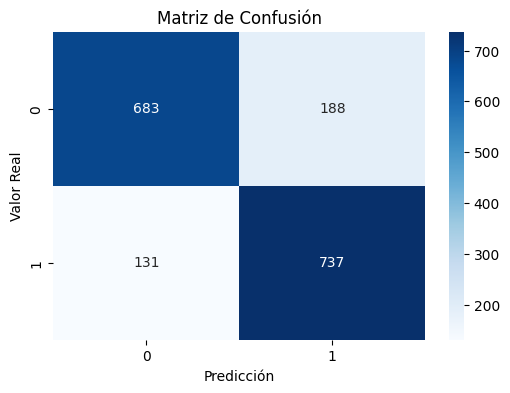

In [ ]:
modelo = joblib.load('model.joblib')

# Hacer predicción
y_pred = modelo.predict(df_new_test)

cm = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Configurar títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Submission a Kaggle

Para poder evaluar nuestro modelo con el conjunto de prueba prporcionado por Kaggle, se predijo la columna *Transported* utilizando el conjunto de prueba de la competencia, donde lo único que se entrega es un .csv con la columna *PassengerId* y *Transported*.

In [ ]:
test = pd.read_csv("test.csv")
id = test["PassengerId"]
id

0       0013_01
1       0018_01
2       0019_01
3       0021_01
4       0023_01
         ...   
4272    9266_02
4273    9269_01
4274    9271_01
4275    9273_01
4276    9277_01
Name: PassengerId, Length: 4277, dtype: object

In [ ]:
# Separar datos numéricos y categóricos
df_cat, df_num = num_cat_separation(test)

# Codifica los datos categóricos
df_cat = encode_dataframe(df_cat)

# Crear los diccionarios de conteo de clases y valores faltantes
class_counts_num, missing_values_num = storeMS(df_num)
class_counts_cat, missing_values_cat = storeMS(df_cat)

# Imputación de datos
imputation(df_num, class_counts_num, missing_values_num)
imputation(df_cat, class_counts_cat, missing_values_cat)

# Combina los DataFrames de datos numéricos y categóricos
df_new = combine_num_cat(df_cat, df_num)

df_new.head()

CryoSleep    VIP              Name  Has_family  HomePlanet_Earth  \
0       True  False   Nelly Carsoning       False              True   
1      False  False    Lerome Peckers       False              True   
2       True  False   Sabih Unhearfus       False             False   
3      False  False  Meratz Caltilter       False             False   
4      False  False   Brence Harperez       False              True   

   HomePlanet_Europa  HomePlanet_Mars  Deck  Side_P  Side_S  \
0              False            False     6   False    True   
1              False            False     5   False    True   
2               True            False     2   False    True   
3               True            False     2   False    True   
4              False            False     5   False    True   

   Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                    False                      False   
1                    False                      False   
2                     True                      False   
3                    False                      False   
4                    False                      False   

   Destination_TRAPPIST-1e   Age  RoomService  FoodCourt  ShoppingMall  \
0                     True  27.0          0.0        0.0           0.0   
1                     True  19.0          0.0        9.0           0.0   
2                    False  31.0          0.0        0.0           0.0   
3                     True  38.0          0.0     6652.0           0.0   
4                     True  20.0         10.0        0.0         635.0   

      Spa  VRDeck  
0     0.0     0.0  
1  2823.0     0.0  
2     0.0     0.0  
3   181.0   585.0  
4     0.0     0.0

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   bool   
 1   VIP                        4277 non-null   bool   
 2   Name                       4277 non-null   object 
 3   Has_family                 4277 non-null   bool   
 4   HomePlanet_Earth           4277 non-null   bool   
 5   HomePlanet_Europa          4277 non-null   bool   
 6   HomePlanet_Mars            4277 non-null   bool   
 7   Deck                       4277 non-null   int64  
 8   Side_P                     4277 non-null   bool   
 9   Side_S                     4277 non-null   bool   
 10  Destination_55 Cancri e    4277 non-null   bool   
 11  Destination_PSO J318.5-22  4277 non-null   bool   
 12  Destination_TRAPPIST-1e    4277 non-null   bool   
 13  Age                        4277 non-null   float

In [ ]:
df_new.drop(columns = ['Name'], inplace = True)

### Predicciones para el conjunto de prueba

In [ ]:
#Importar modelo
import joblib

modelo = joblib.load('model.joblib')
result = modelo.predict(df_new)

In [ ]:
# Crear un DataFrame a partir de estas listas
df = pd.DataFrame({
    'PassengerId': id,
    'Transported': result
})

In [ ]:
df.head()

PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True

In [ ]:
df.to_csv('submission.csv', index=False)

# Conclusión

Lo primero que logramos fue hacer uso de técnicas de análisis e imputación de datos sobre el dataset elegido para favorecer un modelo de clasificación que predijera si un pasajero había sido transportado a otra dimensión, un problema basado en el dataset de los sobrevivientes del Titanic.

Se eligió un modelo de clasificación, dicha elección fue respaldada por métricas como accuracy, recall, presicion y f1, así como una comparación directa obteniendo los valores promedio de dichas métricas y graficando las diferencias críticas entre modelos. Por último, comparamos directamente los dos modelos que mejor resultado nos dieron a través de una comparación bayesiana, lo que terminó por darle la victoria a Catboost.

Una vez elegido el modelo, ajustamos los hiperparámetros haciendo uso de técnicas como GridSearch y RandomSearch, lo que automatizó la búsqueda de la mejor combinación de estos valores.

Finalmente logramos conseguir un modelo que consiguió un 0.80523 en Kaggle, lo que nos dió un ranking de 222 en dicha competencia.
